#### Setup EPPY environment

In [2]:
from eppy import modeleditor
from eppy.modeleditor import IDF
import subprocess
import numpy as np
from bs4 import BeautifulSoup, SoupStrainer
from meteostat import Stations
import requests
import diyepw
import pandas as pd

In [3]:
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [4]:
iddfile = r"/Applications/EnergyPlus-22-2-0/PreProcess/IDFVersionUpdater/V22-2-0-Energy+.idd"
IDF.setiddname(iddfile)
houseFile = r"/Applications/EnergyPlus-22-2-0/ExampleFiles/AirflowNetwork_MultiZone_House_TwoSpeed.idf"
idf1 = IDF(houseFile)

#### Access and change CA metadataset

In [5]:
CA_metadata = pd.read_csv('CA_baseline_metadata_and_annual_results.csv')

cooling_setpoints = [int(setpointString[:-1]) for setpointString in list(CA_metadata['in.cooling_setpoint']) ]
CA_metadata['in.cooling_setpoint'] = cooling_setpoints

heating_setpoints = [int(setpointString[:-1]) for setpointString in list(CA_metadata['in.heating_setpoint']) ]
CA_metadata['in.heating_setpoint'] = heating_setpoints

cooling_offsets = [int(setpointString[:-1]) for setpointString in list(CA_metadata['in.cooling_setpoint_offset_magnitude']) ]
CA_metadata['in.cooling_setpoint_offset_magnitude'] = cooling_offsets

heating_offsets = [int(setpointString[:-1]) for setpointString in list(CA_metadata['in.heating_setpoint_offset_magnitude']) ]
CA_metadata['in.heating_setpoint_offset_magnitude'] = heating_offsets

newCounty = [county[1:3] + county[4:7] for county in CA_metadata['in.county']]
CA_metadata['FIPS'] = newCounty

In [6]:
house = CA_metadata.loc[0]

#### Function that runs energy plus simulation from command line and saves the output dataframe

In [7]:
#return panda dataframe data for given energy plus inputs
def runEnergyPlus(directory,foldername,weatherFile,houseFile):
    simulationCommand = "energyplus --readvars -w " + weatherFile + " -a " + houseFile
    subprocess.run('mkdir '+directory+foldername + "; cd "+directory+foldername+"; "+simulationCommand,shell = True,capture_output = False,stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
    data = pd.read_csv(directory+foldername+r"/eplusmtr.csv")
    return data

#### Schedule function that takes in an integer setpoint in farenheit, temperature off set magnitude, and string description of the offset and returns the idf version

In [8]:
def schedule(setpoint, temperatureOffset, description):
    setpoint = (setpoint - 32) * 5 / 9
    temperatureOffset = temperatureOffset * 4.99/9
    schedules = [
     [["07:00","Night"],["09:00","Neither"],["18:00","Day"],["22:00","Neither"],["24:00","Night"]],
     [["08:00","Night"],["10:00","Neither"],["19:00","Day"],["23:00","Neither"],["24:00","Night"]],
     [["09:00","Night"],["11:00","Neither"],["20:00","Day"],["24:00","Neither"]],
     [["01:00","Neither"],["10:00","Night"],["12:00","Neither"],["21:00","Day"],["24:00","Neither"]],
     [["02:00","Neither"],["11:00","Night"],["13:00","Neither"],["22:00","Day"],["24:00","Neither"]],
     [["03:00","Neither"],["12:00","Night"],["14:00","Neither"],["23:00","Day"],["24:00","Neither"]],
     [["02:00","Night"],["04:00","Neither"],["13:00","Day"],["17:00","Neither"],["24:00","Night"]],
     [["03:00","Night"],["05:00","Neither"],["14:00","Day"],["18:00","Neither"],["24:00","Night"]],
     [["04:00","Night"],["06:00","Neither"],["15:00","Day"],["19:00","Neither"],["24:00","Night"]],
     [["05:00","Night"],["07:00","Neither"],["16:00","Day"],["20:00","Neither"],["24:00","Night"]],
     [["06:00","Night"],["08:00","Neither"],["17:00","Day"],["21:00","Neither"],["24:00","Night"]],
    ]
    base = []
    actualSetpoints = []
    try:
        currentSchedule = schedules[int(description[-3:-1])]
    except Exception as e:
        currentSchedule = schedules[0]
    
    if description == 'None':
        base.append("Until: 24:00")
        base.append(setpoint)
        actualSetpoints.append(setpoint)
    elif "Day Setup and Night Setback" in description:
        setpoints = {"Night": setpoint - temperatureOffset, "Day":setpoint + temperatureOffset,"Neither":setpoint}
        for pair in currentSchedule:
            base.append("Until: " + pair[0])
            base.append(setpoints[pair[1]])
            actualSetpoints.append(setpoints[pair[1]])
    elif "Day Setback and Night Setup" in description:
        setpoints = {"Night": setpoint + temperatureOffset, "Day":setpoint - temperatureOffset,"Neither":setpoint}
        for pair in currentSchedule:
            base.append("Until: " + pair[0])
            base.append(setpoints[pair[1]])
            actualSetpoints.append(setpoints[pair[1]])
    elif "Day and Night Setup" in description:
        setpoints = {"Night": setpoint + temperatureOffset, "Day":setpoint + temperatureOffset,"Neither":setpoint}
        for pair in currentSchedule:
            base.append("Until: " + pair[0])
            base.append(setpoints[pair[1]])
            actualSetpoints.append(setpoints[pair[1]])
    elif "Day and Night Setback" in description:
        setpoints = {"Night": setpoint - temperatureOffset, "Day":setpoint - temperatureOffset,"Neither":setpoint}
        for pair in currentSchedule:
            base.append("Until: " + pair[0])
            base.append(setpoints[pair[1]])
            actualSetpoints.append(setpoints[pair[1]])
    elif "Day Setup" in description:
        setpoints = {"Night": setpoint, "Day":setpoint + temperatureOffset,"Neither":setpoint}
        for pair in currentSchedule:
            base.append("Until: " + pair[0])
            base.append(setpoints[pair[1]])
            actualSetpoints.append(setpoints[pair[1]])
    elif "Day Setback" in description:
        setpoints = {"Night": setpoint, "Day":setpoint - temperatureOffset,"Neither":setpoint}
        for pair in currentSchedule:
            base.append("Until: " + pair[0])
            base.append(setpoints[pair[1]])
            actualSetpoints.append(setpoints[pair[1]])
    elif "Night Setup" in description:
        setpoints = {"Night": setpoint + temperatureOffset, "Day":setpoint,"Neither":setpoint}
        for pair in currentSchedule:
            base.append("Until: " + pair[0])
            base.append(setpoints[pair[1]])
            actualSetpoints.append(setpoints[pair[1]])
    elif "Night Setback" in description:
        setpoints = {"Night": setpoint - temperatureOffset, "Day":setpoint,"Neither":setpoint}
        for pair in currentSchedule:
            base.append("Until: " + pair[0])
            base.append(setpoints[pair[1]])
            actualSetpoints.append(setpoints[pair[1]])

    return base, actualSetpoints

In [9]:
def heatSchedule(setpoint, temperatureOffset, description):
    setpoint = (setpoint - 32) * 5 / 9
    temperatureOffset = temperatureOffset * 5/9
    schedules = [
     [["07:00","Night"],["09:00","Neither"],["18:00","Day"],["22:00","Neither"],["24:00","Night"]],
     [["08:00","Night"],["10:00","Neither"],["19:00","Day"],["23:00","Neither"],["24:00","Night"]],
     [["09:00","Night"],["11:00","Neither"],["20:00","Day"],["24:00","Neither"]],
     [["01:00","Neither"],["10:00","Night"],["12:00","Neither"],["21:00","Day"],["24:00","Neither"]],
     [["02:00","Neither"],["11:00","Night"],["13:00","Neither"],["22:00","Day"],["24:00","Neither"]],
     [["03:00","Neither"],["12:00","Night"],["14:00","Neither"],["23:00","Day"],["24:00","Neither"]],
     [["02:00","Night"],["04:00","Neither"],["13:00","Day"],["17:00","Neither"],["24:00","Night"]],
     [["03:00","Night"],["05:00","Neither"],["14:00","Day"],["18:00","Neither"],["24:00","Night"]],
     [["04:00","Night"],["06:00","Neither"],["15:00","Day"],["19:00","Neither"],["24:00","Night"]],
     [["05:00","Night"],["07:00","Neither"],["16:00","Day"],["20:00","Neither"],["24:00","Night"]],
     [["06:00","Night"],["08:00","Neither"],["17:00","Day"],["21:00","Neither"],["24:00","Night"]],
    ]
    base = []
    actualSetpoints = []
    try:
        currentSchedule = schedules[int(description[-3:-1])]
    except Exception as e:
        currentSchedule = schedules[0]
    
    if description == 'None':
        base.append("Until: 24:00")
        base.append(setpoint)
        actualSetpoints.append(setpoint)
    elif "Day and Night" in description:
        setpoints = {"Night": setpoint - temperatureOffset, "Day":setpoint - temperatureOffset,"Neither":setpoint}
        for pair in currentSchedule:
            base.append("Until: " + pair[0])
            base.append(setpoints[pair[1]])
            actualSetpoints.append(setpoints[pair[1]])
    elif "Day" in description:
        setpoints = {"Night": setpoint, "Day":setpoint - temperatureOffset,"Neither":setpoint}
        for pair in currentSchedule:
            base.append("Until: " + pair[0])
            base.append(setpoints[pair[1]])
            actualSetpoints.append(setpoints[pair[1]])
    elif "Night" in description:
        setpoints = {"Night": setpoint - temperatureOffset, "Day":setpoint,"Neither":setpoint}
        for pair in currentSchedule:
            base.append("Until: " + pair[0])
            base.append(setpoints[pair[1]])
            actualSetpoints.append(setpoints[pair[1]])
    return base, actualSetpoints

#### update schedule function that takes in the idf file and house characteristics and updates the file

In [245]:
def updateSchedule(idfFile, cooling_setpoint, cooling_offset_magnitude, cooling_offset_description, heating_setpoint, heating_offset_magnitude, heating_offset_description):
 
    for obj in idfFile.idfobjects["SCHEDULE:COMPACT"]:
        if obj.Name == "Dual Cooling Setpoints":coolingSchedule = obj
        if obj.Name == "Dual Heating Setpoints":heatingSchedule = obj

    idfFile.removeidfobject(coolingSchedule)
    idfFile.removeidfobject(heatingSchedule)

    newCoolingSchedule = idfFile.newidfobject("SCHEDULE:COMPACT")
    newCoolingSchedule.Name = "Dual Cooling Setpoints"
    newCoolingSchedule.Schedule_Type_Limits_Name = "Temperature"
    newCoolingSchedule.Field_1 = "Through: 12/31"
    newCoolingSchedule.Field_2 = "For: AllDays"

    newHeatingSchedule = idfFile.newidfobject("SCHEDULE:COMPACT")
    newHeatingSchedule.Name = "Dual Heating Setpoints"
    newHeatingSchedule.Schedule_Type_Limits_Name = "Temperature"
    newHeatingSchedule.Field_1 = "Through: 12/31"
    newHeatingSchedule.Field_2 = "For: AllDays"
    
    dicti, cooling_vals = schedule(cooling_setpoint,cooling_offset_magnitude,cooling_offset_description)
    dicti, heating_vals = heatSchedule(heating_setpoint,heating_offset_magnitude,heating_offset_description)

    if min(cooling_vals) <= max(heating_vals):
        heating_setpoint = cooling_setpoint -2
        cooling_offset_magnitude = 0
        heating_offset_magnitude = 0

    i = 3
    
    dicti, cooling_vals = schedule(cooling_setpoint,cooling_offset_magnitude,cooling_offset_description)
    for val in dicti:
        newCoolingSchedule["Field_" + str(i)] = val
        i+=1
        
    i = 3
    
    dicti, heating_vals = heatSchedule(heating_setpoint,heating_offset_magnitude,heating_offset_description)

    for val in dicti:
        newHeatingSchedule["Field_" + str(i)] = val
        i+=1
        
    return max(heating_vals)

#### Function that modifies the geometry of a house to scale the square footage

In [11]:
#scale multizone house geometry to fit the square footage
def updateSQFT(idfFile, sqft):
    for surface in idfFile.idfobjects["BUILDINGSURFACE:DETAILED"]:
        surface_dict = {surface.objls[i]: surface.obj[i] for i in range(len(surface.obj))}
        for key in surface_dict.keys():
            if 'Xcoordinate' in key or 'Ycoordinate' in key:
                surface[key] = surface[key] * sqft/2000
                
    for surface in idfFile.idfobjects["FenestrationSurface:Detailed"]:
        surface_dict = {surface.objls[i]: surface.obj[i] for i in range(len(surface.obj))}
        for key in surface_dict.keys():
            if 'Xcoordinate' in key or 'Ycoordinate' in key:
                surface[key] = surface[key] * sqft/2000           

#### function that sets duct leakage

In [12]:
pd.unique(CA_metadata["in.ducts"])

array(['10% Leakage, R-4', '10% Leakage, Uninsulated', '20% Leakage, R-4',
       'None', '20% Leakage, Uninsulated', '20% Leakage, R-6',
       '0% Leakage, Uninsulated', '20% Leakage, R-8', '30% Leakage, R-4',
       '30% Leakage, Uninsulated', '30% Leakage, R-8', '10% Leakage, R-8',
       '30% Leakage, R-6', '10% Leakage, R-6'], dtype=object)

In [13]:
def getLeakageRatio(ductDescription):
    if '%' in ductDescription:
        numstr = ''
        for char in ductDescription: 
            if char != '%': numstr+=char
            else:
                break
        ratio = int(numstr) / 100 
        if ratio == 0: ratio = 0.01
    else: 
        ratio = 0.01
    return ratio

def updateLeakageRatio(idfFile,ductDescription):
    ratio = getLeakageRatio(ductDescription)
    for duct in idfFile.idfobjects["AirflowNetwork:Distribution:Component:LeakageRatio"]:
        duct["Effective_Leakage_Ratio"] = ratio

#### update idf file for a given house (row from metadata)

In [413]:
print(idf1.idfobjects["SCHEDULE:COMPACT"][-2])
print(idf1.idfobjects["SCHEDULE:COMPACT"][-1])


SCHEDULE:COMPACT,
    Dual Cooling Setpoints,    !- Name
    Temperature,              !- Schedule Type Limits Name
    Through: 12/31,           !- Field 1
    For: AllDays,             !- Field 2
    Until: 24:00,             !- Field 3
    21.11111111111111;        !- Field 4


SCHEDULE:COMPACT,
    Dual Heating Setpoints,    !- Name
    Temperature,              !- Schedule Type Limits Name
    Through: 12/31,           !- Field 1
    For: AllDays,             !- Field 2
    Until: 05:00,             !- Field 3
    25,                       !- Field 4
    Until: 07:00,             !- Field 5
    26.666666666666668,       !- Field 6
    Until: 16:00,             !- Field 7
    26.666666666666668,       !- Field 8
    Until: 20:00,             !- Field 9
    26.666666666666668,       !- Field 10
    Until: 24:00,             !- Field 11
    25;                       !- Field 12



In [412]:
#update cooling and heating setpoints
updateSchedule(idf1, house['in.cooling_setpoint'],house['in.cooling_setpoint_offset_magnitude'],house['in.cooling_setpoint_offset_period'],house['in.heating_setpoint'],house['in.heating_setpoint_offset_magnitude'],house['in.heating_setpoint_offset_period'])

In [301]:
updateSQFT(idf1,house['in.sqft'])

#### Square Footage Scaling Sensitivity Analysis

In [369]:
directory  = r"/Applications/EnergyPlus-22-2-0/CCRG_Simulations/sqft_sensitivity/"
weatherFile = r"/Applications/EnergyPlus-22-2-0/WeatherData/Chicago5A.epw"
sqft_x = list(range(600,3600,150))
sqft_data = pd.DataFrame(index =sqft_x, columns = ['Electricity:Facility [J](RunPeriod)',
                                                                   'Electricity:Building [J](RunPeriod)',
                                                                   'Electricity:HVAC [J](RunPeriod)',
                                                                   'NaturalGas:Facility [J](RunPeriod)',
                                                                   'NaturalGas:HVAC [J](RunPeriod) '])

defaultHouse = r"/Applications/EnergyPlus-22-2-0/ExampleFiles/AirflowNetwork_MultiZone_House_TwoSpeed.idf"

for sqft in range(600,3600,150):
    idf1 = IDF(defaultHouse)
    updateSQFT(idf1,sqft)
    idf1.save(r"/Applications/EnergyPlus-22-2-0/ExampleFiles/" + str(sqft) + ".idf")
    
    foldername = str(sqft)
    houseFile = r"/Applications/EnergyPlus-22-2-0/ExampleFiles/" + str(sqft) + ".idf"
    
    data = runEnergyPlus(directory,foldername,weatherFile,houseFile)
    last_col = data.iloc[-1]
    sqft_data.loc[sqft, ['Electricity:Facility [J](RunPeriod)',
                        'Electricity:Building [J](RunPeriod)',
                        'Electricity:HVAC [J](RunPeriod)',
                        'NaturalGas:Facility [J](RunPeriod)',
                        'NaturalGas:HVAC [J](RunPeriod) ']] = list(last_col[5:7]) + list(last_col[8:])
    
    clear_output()
    print(sqft_data)

     Electricity:Facility [J](RunPeriod) Electricity:Building [J](RunPeriod)  \
600                   35077377420.905914                       15764760000.0   
750                                  NaN                                 NaN   
900                                  NaN                                 NaN   
1050                                 NaN                                 NaN   
1200                                 NaN                                 NaN   
1350                                 NaN                                 NaN   
1500                                 NaN                                 NaN   
1650                                 NaN                                 NaN   
1800                                 NaN                                 NaN   
1950                                 NaN                                 NaN   
2100                                 NaN                                 NaN   
2250                                 NaN

FileNotFoundError: [Errno 2] No such file or directory: '/Applications/EnergyPlus-22-2-0/CCRG_Simulations/sqft_sensitivity/750/eplusmtr.csv'

In [430]:
sqft_data['Electricity:Facility [J](RunPeriod)'] *=  2.777778*10**(-7)
sqft_data['Electricity:Building [J](RunPeriod)']*=  2.777778*10**(-7)
sqft_data['Electricity:HVAC [J](RunPeriod)']*=  2.777778*10**(-7)
sqft_data['NaturalGas:Facility [J](RunPeriod)']*=  2.777778*10**(-7)
sqft_data['NaturalGas:HVAC [J](RunPeriod) ']*=  2.777778*10**(-7)
sqft_data['HP_total_hvac'] = sqft_data['Electricity:HVAC [J](RunPeriod)'] + sqft_data['NaturalGas:HVAC [J](RunPeriod) ']

Text(0, 0.5, 'KwH HVAC Energy')

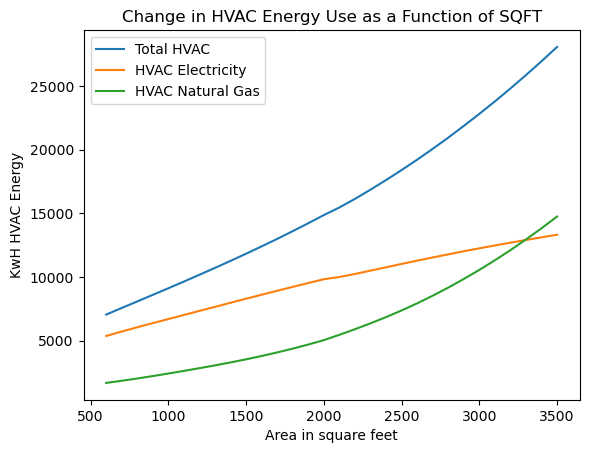

In [432]:
plt.plot(sqft_x,sqft_data['HP_total_hvac'],label = "Total HVAC")
plt.plot(sqft_x,sqft_data['Electricity:HVAC [J](RunPeriod)'],label = "HVAC Electricity")
plt.plot(sqft_x,sqft_data['NaturalGas:HVAC [J](RunPeriod) '],label = "HVAC Natural Gas")
plt.legend()
plt.title("Change in HVAC Energy Use as a Function of SQFT")
plt.xlabel("Area in square feet")
plt.ylabel("KwH HVAC Energy")

#### Heating and Cooling Setpoints Sensitivity Analysis

In [420]:
directory  = r"/Applications/EnergyPlus-22-2-0/CCRG_Simulations/setpoint_sensitivity/"
weatherFile = r"/Applications/EnergyPlus-22-2-0/WeatherData/Chicago5A.epw"
coolingSetpoint = list(range(70,85,1))
heatingSetpoint = list(range(70,55,-1))
setpointData = pd.DataFrame(index =list(range(0,30,1)), columns = ['Electricity:Facility [J](RunPeriod)',
                                                                   'Electricity:Building [J](RunPeriod)',
                                                                   'Electricity:HVAC [J](RunPeriod)',
                                                                   'NaturalGas:Facility [J](RunPeriod)',
                                                                   'NaturalGas:HVAC [J](RunPeriod) '])

defaultHouse = r"/Applications/EnergyPlus-22-2-0/ExampleFiles/AirflowNetwork_MultiZone_House_TwoSpeed.idf"

for i in range(len(coolingSetpoint)):
    idf1 = IDF(defaultHouse)
    updateSchedule(idf1, coolingSetpoint[i], 0, 'None', heatingSetpoint[i], 0, 'None')
    idf1.save(r"/Applications/EnergyPlus-22-2-0/ExampleFiles/setpoint_differential_" + str(i) + ".idf")
    
    foldername = str(i)
    houseFile = r"/Applications/EnergyPlus-22-2-0/ExampleFiles/setpoint_differential_" + str(i) + ".idf"
    
    data = runEnergyPlus(directory,foldername,weatherFile,houseFile)
    last_col = data.iloc[-1]
    setpointData.loc[i, ['Electricity:Facility [J](RunPeriod)',
                        'Electricity:Building [J](RunPeriod)',
                        'Electricity:HVAC [J](RunPeriod)',
                        'NaturalGas:Facility [J](RunPeriod)',
                        'NaturalGas:HVAC [J](RunPeriod) ']] = list(last_col[5:7]) + list(last_col[8:])
    
    clear_output()
    print(setpointData)

   Electricity:Facility [J](RunPeriod) Electricity:Building [J](RunPeriod)  \
0                   56024389047.512459                       15764760000.0   
1                   53922052277.814217                       15764760000.0   
2                   52078925980.932793                       15764760000.0   
3                   50356914207.792007                       15764760000.0   
4                   48690885290.269997                       15764760000.0   
5                   47073559323.851418                       15764760000.0   
6                   45562169625.754082                       15764760000.0   
7                   44254949678.147186                       15764760000.0   
8                   42963910695.161003                       15764760000.0   
9                   41688395296.100655                       15764760000.0   
10                  40432636529.073723                       15764760000.0   
11                  39196360825.607384                       157

In [421]:
setpointData['Electricity:Facility [J](RunPeriod)'] *=  2.777778*10**(-7)
setpointData['Electricity:Building [J](RunPeriod)']*=  2.777778*10**(-7)
setpointData['Electricity:HVAC [J](RunPeriod)']*=  2.777778*10**(-7)
setpointData['NaturalGas:Facility [J](RunPeriod)']*=  2.777778*10**(-7)
setpointData['NaturalGas:HVAC [J](RunPeriod) ']*=  2.777778*10**(-7)
setpointData['HP_total_hvac'] = setpointData['Electricity:HVAC [J](RunPeriod)'] + setpointData['NaturalGas:HVAC [J](RunPeriod) ']

Text(0, 0.5, 'KwH HVAC Energy')

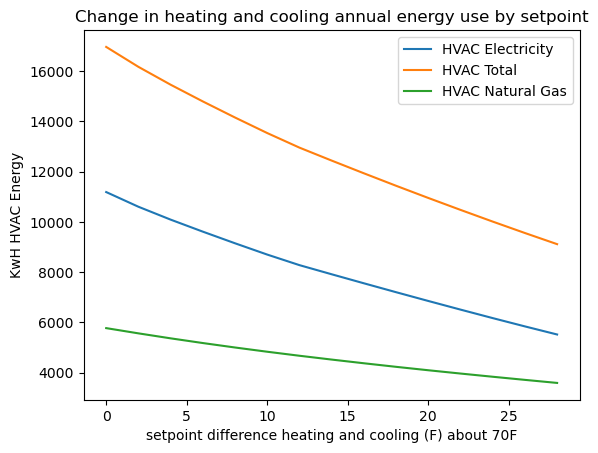

In [428]:
plt.plot(list(range(0,60,2)),setpointData['Electricity:HVAC [J](RunPeriod)'],label = "HVAC Electricity")
plt.plot(list(range(0,60,2)),setpointData['HP_total_hvac'], label = "HVAC Total")
plt.plot(list(range(0,60,2)),setpointData['NaturalGas:HVAC [J](RunPeriod) '],label = "HVAC Natural Gas")
plt.legend()
plt.title("Change in heating and cooling annual energy use by setpoint")
plt.xlabel("setpoint difference heating and cooling (F) about 70F")
plt.ylabel("KwH HVAC Energy")

#### Duct Leakage Sensitivity Analysis

In [442]:
directory  = r"/Applications/EnergyPlus-22-2-0/CCRG_Simulations/leakage_ratio_sensitivity/"
weatherFile = r"/Applications/EnergyPlus-22-2-0/WeatherData/Chicago5A.epw"
ductLeakage = list(np.linspace(0.01,0.2,num = 20))
leakageData = pd.DataFrame(index =list(np.linspace(0.01,0.2,num = 20)), columns = ['Electricity:Facility [J](RunPeriod)',
                                                                   'Electricity:Building [J](RunPeriod)',
                                                                   'Electricity:HVAC [J](RunPeriod)',
                                                                   'NaturalGas:Facility [J](RunPeriod)',
                                                                   'NaturalGas:HVAC [J](RunPeriod) '])

defaultHouse = r"/Applications/EnergyPlus-22-2-0/ExampleFiles/AirflowNetwork_MultiZone_House_TwoSpeed.idf"

for i in np.linspace(0.01,0.2,num = 20):
    idf1 = IDF(defaultHouse)
    idf1.idfobjects["AirflowNetwork:Distribution:Component:LeakageRatio"][0]["Effective_Leakage_Ratio"] = i
    idf1.idfobjects["AirflowNetwork:Distribution:Component:LeakageRatio"][1]["Effective_Leakage_Ratio"] = i
    idf1.save(r"/Applications/EnergyPlus-22-2-0/ExampleFiles/leakage_ratio_" + str(i) + ".idf")
    
    foldername = str(i)
    houseFile = r"/Applications/EnergyPlus-22-2-0/ExampleFiles/leakage_ratio_" + str(i) + ".idf"
    
    data = runEnergyPlus(directory,foldername,weatherFile,houseFile)
    last_col = data.iloc[-1]
    leakageData.loc[i, ['Electricity:Facility [J](RunPeriod)',
                        'Electricity:Building [J](RunPeriod)',
                        'Electricity:HVAC [J](RunPeriod)',
                        'NaturalGas:Facility [J](RunPeriod)',
                        'NaturalGas:HVAC [J](RunPeriod) ']] = list(last_col[5:7]) + list(last_col[8:])
    
    clear_output()
    print(leakageData)

     Electricity:Facility [J](RunPeriod) Electricity:Building [J](RunPeriod)  \
0.01                  50438229295.057732                       15764760000.0   
0.02                  50666671457.822922                       15764760000.0   
0.03                  50891048214.348358                       15764760000.0   
0.04                  51112623527.349297                       15764760000.0   
0.05                  51330798772.330566                       15764760000.0   
0.06                  51545817254.392059                       15764760000.0   
0.07                  51759327688.157089                       15764760000.0   
0.08                  51977276893.328262                       15764760000.0   
0.09                  52196753443.970238                       15764760000.0   
0.10                  52416982342.317642                       15764760000.0   
0.11                  52636706976.270264                       15764760000.0   
0.12                  52855176231.782166

In [444]:
leakageData['Electricity:Facility [J](RunPeriod)'] *=  2.777778*10**(-7)
leakageData['Electricity:Building [J](RunPeriod)']*=  2.777778*10**(-7)
leakageData['Electricity:HVAC [J](RunPeriod)']*=  2.777778*10**(-7)
leakageData['NaturalGas:Facility [J](RunPeriod)']*=  2.777778*10**(-7)
leakageData['NaturalGas:HVAC [J](RunPeriod) ']*=  2.777778*10**(-7)
leakageData['HP_total_hvac'] = leakageData['Electricity:HVAC [J](RunPeriod)'] + leakageData['NaturalGas:HVAC [J](RunPeriod) ']

Text(0, 0.5, 'KwH HVAC Energy')

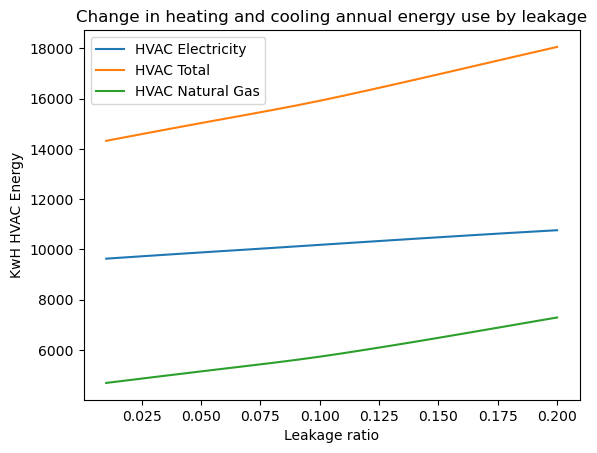

In [445]:
plt.plot(leakageData.index,leakageData['Electricity:HVAC [J](RunPeriod)'],label = "HVAC Electricity")
plt.plot(leakageData.index,leakageData['HP_total_hvac'], label = "HVAC Total")
plt.plot(leakageData.index,leakageData['NaturalGas:HVAC [J](RunPeriod) '],label = "HVAC Natural Gas")
plt.legend()
plt.title("Change in heating and cooling annual energy use by leakage")
plt.xlabel("Leakage ratio")
plt.ylabel("KwH HVAC Energy")

#### Window Air Thickness Sensitivity Analysis

In [462]:
directory  = r"/Applications/EnergyPlus-22-2-0/CCRG_Simulations/window_gas_thickness_sensitivity/"
weatherFile = r"/Applications/EnergyPlus-22-2-0/WeatherData/Chicago5A.epw"
ductLeakage = list(np.linspace(0.001,0.02,num = 20))
windowGasThicknessData = pd.DataFrame(index =list(np.linspace(0.001,0.02,num = 20)), columns = ['Electricity:Facility [J](RunPeriod)',
                                                                   'Electricity:Building [J](RunPeriod)',
                                                                   'Electricity:HVAC [J](RunPeriod)',
                                                                   'NaturalGas:Facility [J](RunPeriod)',
                                                                   'NaturalGas:HVAC [J](RunPeriod) '])

defaultHouse = r"/Applications/EnergyPlus-22-2-0/ExampleFiles/AirflowNetwork_MultiZone_House_TwoSpeed.idf"

for i in np.linspace(0.001,0.02,num = 20):
    idf1 = IDF(defaultHouse)
    idf1.idfobjects["WindowMaterial:Gas"][0]['Thickness'] = i
    idf1.save(r"/Applications/EnergyPlus-22-2-0/ExampleFiles/window_air_thickness_" + str(i) + ".idf")
    
    foldername = str(i)
    houseFile = r"/Applications/EnergyPlus-22-2-0/ExampleFiles/window_air_thickness_" + str(i) + ".idf"
    
    data = runEnergyPlus(directory,foldername,weatherFile,houseFile)
    last_col = data.iloc[-1]
    windowGasThicknessData.loc[i, ['Electricity:Facility [J](RunPeriod)',
                        'Electricity:Building [J](RunPeriod)',
                        'Electricity:HVAC [J](RunPeriod)',
                        'NaturalGas:Facility [J](RunPeriod)',
                        'NaturalGas:HVAC [J](RunPeriod) ']] = list(last_col[5:7]) + list(last_col[8:])
    
    clear_output()
    print(windowGasThicknessData)

      Electricity:Facility [J](RunPeriod) Electricity:Building [J](RunPeriod)  \
0.001                     52592116279.195                       15764760000.0   
0.002                  52074344224.081757                       15764760000.0   
0.003                   51718237522.74308                       15764760000.0   
0.004                    51461098117.9375                       15764760000.0   
0.005                  51265963849.402855                       15764760000.0   
0.006                  51112640684.424942                       15764760000.0   
0.007                  50989289232.287361                       15764760000.0   
0.008                  50887655302.404961                       15764760000.0   
0.009                  50803107246.828819                       15764760000.0   
0.010                  50731323612.884094                       15764760000.0   
0.011                  50670278492.493492                       15764760000.0   
0.012                  50618

In [463]:
windowGasThicknessData['Electricity:Facility [J](RunPeriod)'] *=  2.777778*10**(-7)
windowGasThicknessData['Electricity:Building [J](RunPeriod)']*=  2.777778*10**(-7)
windowGasThicknessData['Electricity:HVAC [J](RunPeriod)']*=  2.777778*10**(-7)
windowGasThicknessData['NaturalGas:Facility [J](RunPeriod)']*=  2.777778*10**(-7)
windowGasThicknessData['NaturalGas:HVAC [J](RunPeriod) ']*=  2.777778*10**(-7)
windowGasThicknessData['HP_total_hvac'] = windowGasThicknessData['Electricity:HVAC [J](RunPeriod)'] + windowGasThicknessData['NaturalGas:HVAC [J](RunPeriod) ']

Text(0, 0.5, 'KwH HVAC Energy')

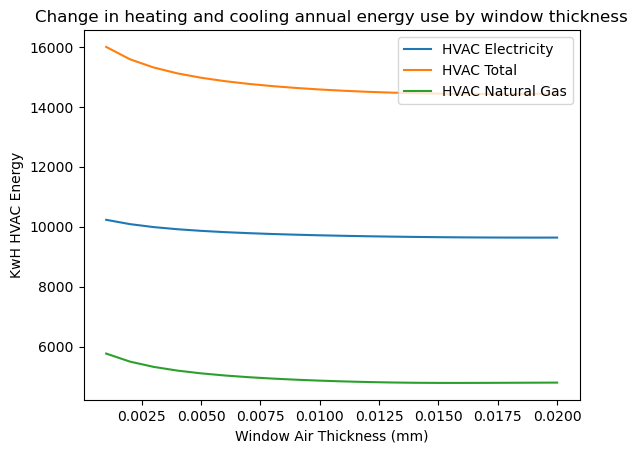

In [468]:
plt.plot(windowGasThicknessData.index,windowGasThicknessData['Electricity:HVAC [J](RunPeriod)'],label = "HVAC Electricity")
plt.plot(windowGasThicknessData.index,windowGasThicknessData['HP_total_hvac'], label = "HVAC Total")
plt.plot(windowGasThicknessData.index,windowGasThicknessData['NaturalGas:HVAC [J](RunPeriod) '],label = "HVAC Natural Gas")
plt.legend()
plt.title("Change in heating and cooling annual energy use by window thickness")
plt.xlabel("Window Air Thickness (mm)")
plt.ylabel("KwH HVAC Energy")

#### Function to get total HVAC from ResStock outputs

In [195]:
def get_total_HVAC(dataframe):
    return (dataframe['out.electricity.cooling.energy_consumption.kwh'] + 
            dataframe['out.electricity.cooling_fans_pumps.energy_consumption.kwh'] + 
            dataframe['out.electricity.heating_fans_pumps.energy_consumption.kwh'] + 
            dataframe['out.electricity.heating_hp_bkup.energy_consumption.kwh'] + 
            dataframe['out.electricity.heating.energy_consumption.kwh'] + 
            dataframe['out.fuel_oil.heating.energy_consumption.kwh'] + 
            dataframe['out.fuel_oil.heating_hp_bkup.energy_consumption.kwh'] + 
            dataframe['out.natural_gas.heating.energy_consumption.kwh'] + 
            dataframe['out.natural_gas.heating_hp_bkup.energy_consumption.kwh'] + 
            dataframe['out.propane.heating_hp_bkup.energy_consumption.kwh'] + 
            dataframe['out.propane.heating.energy_consumption.kwh'])

#### Download and create cleaned dataframe of county IDs and latitude and longitude coordinates

In [15]:
#download table from wikipedia with county lat and lon coords
path = 'User_Michael J_County table - Wikipedia.html'

# empty list
data = []

# for getting the header from
# the HTML file
list_header = []
soup = BeautifulSoup(open(path),'html.parser')
header = soup.find_all("table")[0].find("tr")

for items in header:
	try:
		list_header.append(items.get_text())
	except:
		continue

# for getting the data
HTML_data = soup.find_all("table")[0].find_all("tr")[1:]

for element in HTML_data:
	sub_data = []
	for sub_element in element:
		try:
			sub_data.append(sub_element.get_text())
		except:
			continue
	data.append(sub_data)

# Storing the data into Pandas
# DataFrame
countiesLatsLons = pd.DataFrame(data = data, columns = list_header)

#clean up data getting rid of non-numerical symbols
countiesLatsLons = countiesLatsLons[['FIPS','Latitude','Longitude\n']]
lats = list(countiesLatsLons['Latitude'])
newlats = []
for lat in lats:
    newlats.append(float(lat[0:-1]))
    
lons = list(countiesLatsLons['Longitude\n'])
newlons = []
for lon in lons:
    newlons.append(float(lon[1:-3])*-1) #<--------------- change this when doing whole US< assumes negative longitude
    
countiesLatsLons['Latitude'] = newlats
countiesLatsLons['Longitude\n'] = newlons
countiesLatsLons = countiesLatsLons.set_index('FIPS')

In [16]:
countiesLatsLons

,Latitude,Longitude\n
FIPS,,
01001,32.536382,-86.64449
01003,30.659218,-87.74606
01005,31.870670,-85.40545
01007,33.015893,-87.12714
01009,33.977448,-86.56724
...,...,...
56037,41.660339,-108.87567
56039,44.049321,-110.58810
56041,41.284726,-110.55894


#### Get list of noaa weather files

In [73]:
url = 'https://www1.ncdc.noaa.gov/pub/data/noaa/isd-lite/2022/'
reqs = requests.get(url)
soup = BeautifulSoup(reqs.text, 'html.parser')
urls = []
for link in soup.find_all('a'):
    linkName = link.get('href')
    if 'gz' in linkName:
        urls.append(linkName)

#### Get the id for the noaa station given latitude and longitude

In [68]:
URL = "https://www1.ncdc.noaa.gov/pub/data/noaa/isd-lite/2022/"
stations = Stations()
def getIDs(lat,lon):
    near = stations.nearby(lat, lon).fetch()
    near = near.loc[near['wmo'] !='<NA>']
    return near.iloc[0:10]['wmo'] #returns the 10 closest weather stations IDs

#### Get the file name from the noaa webstite that matches the latitude and longitude coords

In [69]:
def getFile(lat,lon):
    IDs = getIDs(lat,lon)
    matching = []
    for ID in IDs:
        for url in urls:
            if str(ID) in url: 
                matching.append([url[0:6],url]) #returns every matching station file for each of the
            #ten closest weather IDs
    return matching

#### Download all necessary weather files and store path locations

In [221]:
newCounty = [county[1:3] + county[4:7] for county in IL_metadata['in.county']]
IL_metadata['FIPS'] = newCounty
counties = pd.unique(IL_metadata['FIPS'])

newCounty = [county[1:3] + county[4:7] for county in CA_metadata['in.county']]
CA_metadata['FIPS'] = newCounty
counties = np.append(counties, pd.unique(CA_metadata['FIPS']))
print(counties)

['17031' '17097' '17203' '17043' '17167' '17161' '17111' '17099' '17197'
 '17119' '17131' '17033' '17115' '17057' '17125' '17107' '17063' '17173'
 '17201' '17141' '17089' '17159' '17095' '17113' '17149' '17181' '17195'
 '17139' '17163' '17179' '17015' '17091' '17079' '17019' '17193' '17007'
 '17029' '17183' '17021' '17143' '17081' '17187' '17157' '17055' '17145'
 '17035' '17135' '17001' '17147' '17133' '17171' '17027' '17121' '17067'
 '17093' '17017' '17073' '17101' '17085' '17199' '17177' '17137' '17037'
 '17077' '17025' '17039' '17075' '17011' '17185' '17189' '17103' '17049'
 '17009' '17109' '17053' '17153' '17151' '17129' '17065' '17165' '17087'
 '17023' '17047' '17127' '17005' '17117' '17175' '17045' '17003' '17071'
 '17069' '17105' '17051' '17155' '17061' '17191' '17041' '17123' '17083'
 '17059' '17169' '17013' '06073' '06111' '06023' '06059' '06075' '06037'
 '06081' '06071' '06065' '06035' '06067' '06013' '06069' '06097' '06041'
 '06053' '06083' '06087' '06079' '06085' '06007' '0

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [71]:
import diyepw

In [222]:
import signal
def timeout(func, arg, timeout_duration=1, default=None):
    class TimeoutError(Exception):
        pass

    def handler(signum, frame):
        raise TimeoutError()

    # set the timeout handler
    signal.signal(signal.SIGALRM, handler) 
    signal.alarm(timeout_duration)
    try:
        result = func(arg, 2022, allow_downloads = True)
    except TimeoutError as exc:
        result = default
    finally:
        signal.alarm(0)

    return result

In [223]:
#given a row, find lat and lon coordinates, 
#find corresponding weather file, download it
WMO_File_Names = pd.read_csv('tmy_epw_catalog copy.csv')
for county in counties:
    #print(county)
    latlon = countiesLatsLons.loc[county]
    lat = latlon['Latitude']
    lon = latlon['Longitude\n']
    fileNames = getFile(lat,lon)
    ID = 1
    #iterate through potential weather files until you find a suitable match
    for file in fileNames:
        try:
            ID = file[0]
            print(ID)
            #print(int(file[1][0:6]))
            path = timeout(diyepw.create_amy_epw_file,int(file[1][0:6]),10);
            #print(path)
            break
        except Exception as e: #if the file is not suitable, move to the next file down the priority ranking
            #this should return a file for every single county in the contiguous US
            
            print(e)
    indexFiles = WMO_File_Names.loc[WMO_File_Names['wmo_index'] == int(ID)]
    print(indexFiles.iloc[0])
    countiesLatsLons.loc[countiesLatsLons.index == county,'path1'] = indexFiles.iloc[0]['file_name']
    if indexFiles.shape[0] == 2:
        countiesLatsLons.loc[countiesLatsLons.index == county ,'path2'] = indexFiles.iloc[1]['file_name']
    countiesLatsLons.loc[countiesLatsLons.index == county,'ID']= int(ID)

725340
2023-03-27 00:11:13,285 No amy_epw_dir was specified - generated AMY EPWs will be stored in /var/folders/y_/wsfrr6n944q4gw07ywp8l2_00000gn/T/tmp9n0iabpg
2023-03-27 00:11:13,321 No amy_dir was specified - downloaded AMY files will be stored in the default location at /Users/kyan/opt/anaconda3/lib/python3.9/site-packages/diyepw/data/noaa_isd_lite_files
2023-03-27 00:11:17,326 TMY EPW file (/Users/kyan/opt/anaconda3/lib/python3.9/site-packages/diyepw/data/tmy_epw_files/USA_IL_Chicago.Midway.Intl.AP.725340_TMY3.epw) already exists, won't download again.
wmo_index                                               725340
file_name        USA_IL_Chicago.Midway.Intl.AP.725340_TMY3.epw
url          http://climate.onebuilding.org/WMO_Region_4_No...
Name: 1395, dtype: object
725300
2023-03-27 00:11:20,396 No amy_epw_dir was specified - generated AMY EPWs will be stored in /var/folders/y_/wsfrr6n944q4gw07ywp8l2_00000gn/T/tmp9n0iabpg
2023-03-27 00:11:20,397 No amy_dir was specified - downloaded 

Exception ignored in: <function Popen.__del__ at 0x7fe7af3ccdc0>
Traceback (most recent call last):
  File "/Users/kyan/opt/anaconda3/lib/python3.9/subprocess.py", line 1045, in __del__
    def __del__(self, _maxsize=sys.maxsize, _warn=warnings.warn):
  File "/var/folders/y_/wsfrr6n944q4gw07ywp8l2_00000gn/T/ipykernel_1267/3057385564.py", line 7, in handler
__main__.timeout.<locals>.TimeoutError: 


The longest set of missing records for Sea_Level_Pressure is 8760, but the max allowed is 48
725340
2023-03-27 00:13:28,575 No amy_epw_dir was specified - generated AMY EPWs will be stored in /var/folders/y_/wsfrr6n944q4gw07ywp8l2_00000gn/T/tmp9n0iabpg
2023-03-27 00:13:28,600 No amy_dir was specified - downloaded AMY files will be stored in the default location at /Users/kyan/opt/anaconda3/lib/python3.9/site-packages/diyepw/data/noaa_isd_lite_files
2023-03-27 00:13:29,140 TMY EPW file (/Users/kyan/opt/anaconda3/lib/python3.9/site-packages/diyepw/data/tmy_epw_files/USA_IL_Chicago.Midway.Intl.AP.725340_TMY3.epw) already exists, won't download again.
2023-03-27 00:13:29,548 File already exists at /var/folders/y_/wsfrr6n944q4gw07ywp8l2_00000gn/T/tmp9n0iabpg/USA_IL_Chicago-Midway-Intl-AP.725340_AMY_2022.epw, so a new one won't be generated.
wmo_index                                               725340
file_name        USA_IL_Chicago.Midway.Intl.AP.725340_TMY3.epw
url          http://climat

#### Window Glaze Thickness Sensitivity Analysis

In [465]:
directory  = r"/Applications/EnergyPlus-22-2-0/CCRG_Simulations/window_glaze_thickness_sensitivity/"
weatherFile = r"/Applications/EnergyPlus-22-2-0/WeatherData/Chicago5A.epw"
windowGlazeThicknessData = pd.DataFrame(index =list(np.linspace(0.001,0.01,num = 15)), columns = ['Electricity:Facility [J](RunPeriod)',
                                                                   'Electricity:Building [J](RunPeriod)',
                                                                   'Electricity:HVAC [J](RunPeriod)',
                                                                   'NaturalGas:Facility [J](RunPeriod)',
                                                                   'NaturalGas:HVAC [J](RunPeriod) '])

defaultHouse = r"/Applications/EnergyPlus-22-2-0/ExampleFiles/AirflowNetwork_MultiZone_House_TwoSpeed.idf"

for i in np.linspace(0.001,0.01,num = 15):
    idf1 = IDF(defaultHouse)
    idf1.idfobjects["WindowMaterial:Glazing"][0]['Thickness'] = i
    idf1.save(r"/Applications/EnergyPlus-22-2-0/ExampleFiles/window_glaze_thickness_" + str(i) + ".idf")
    
    foldername = str(i)
    houseFile = r"/Applications/EnergyPlus-22-2-0/ExampleFiles/window_glaze_thickness_" + str(i) + ".idf"
    
    data = runEnergyPlus(directory,foldername,weatherFile,houseFile)
    last_col = data.iloc[-1]
    windowGlazeThicknessData.loc[i, ['Electricity:Facility [J](RunPeriod)',
                        'Electricity:Building [J](RunPeriod)',
                        'Electricity:HVAC [J](RunPeriod)',
                        'NaturalGas:Facility [J](RunPeriod)',
                        'NaturalGas:HVAC [J](RunPeriod) ']] = list(last_col[5:7]) + list(last_col[8:])
    
    clear_output()
    print(windowGlazeThicknessData)

         Electricity:Facility [J](RunPeriod)  \
0.001000                  51164461707.101082   
0.001643                  51147547425.252342   
0.002286                  51131361324.050781   
0.002929                  51114456382.114517   
0.003571                  51098082920.861946   
0.004214                  51081812005.763741   
0.004857                  51065636497.857018   
0.005500                  51049249403.409348   
0.006143                  51033257333.966034   
0.006786                  51017763342.078751   
0.007429                  51002282899.249924   
0.008071                  50986669861.219017   
0.008714                  50971228345.188896   
0.009357                  50955590423.089844   
0.010000                   50940520671.22393   

         Electricity:Building [J](RunPeriod) Electricity:HVAC [J](RunPeriod)  \
0.001000                       15764760000.0              35399701707.099838   
0.001643                       15764760000.0              35382787425.2

In [466]:
windowGlazeThicknessData['Electricity:Facility [J](RunPeriod)'] *=  2.777778*10**(-7)
windowGlazeThicknessData['Electricity:Building [J](RunPeriod)']*=  2.777778*10**(-7)
windowGlazeThicknessData['Electricity:HVAC [J](RunPeriod)']*=  2.777778*10**(-7)
windowGlazeThicknessData['NaturalGas:Facility [J](RunPeriod)']*=  2.777778*10**(-7)
windowGlazeThicknessData['NaturalGas:HVAC [J](RunPeriod) ']*=  2.777778*10**(-7)
windowGlazeThicknessData['HP_total_hvac'] = windowGlazeThicknessData['Electricity:HVAC [J](RunPeriod)'] + windowGlazeThicknessData['NaturalGas:HVAC [J](RunPeriod) ']

Text(0, 0.5, 'KwH HVAC Energy')

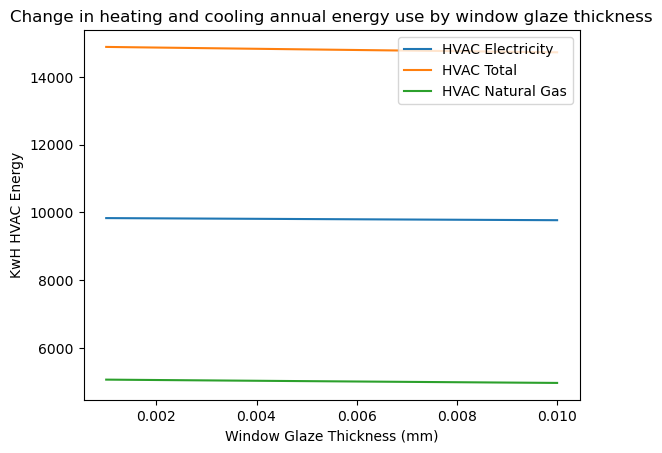

In [469]:
plt.plot(windowGlazeThicknessData.index,windowGlazeThicknessData['Electricity:HVAC [J](RunPeriod)'],label = "HVAC Electricity")
plt.plot(windowGlazeThicknessData.index,windowGlazeThicknessData['HP_total_hvac'], label = "HVAC Total")
plt.plot(windowGlazeThicknessData.index,windowGlazeThicknessData['NaturalGas:HVAC [J](RunPeriod) '],label = "HVAC Natural Gas")
plt.legend()
plt.title("Change in heating and cooling annual energy use by window glaze thickness")
plt.xlabel("Window Glaze Thickness (mm)")
plt.ylabel("KwH HVAC Energy")

#### Crack leakage factors sensitivity analysis

In [20]:
def changeLeakageRatio(idfFile,leakageRatio):
    for i in idfFile.idfobjects["AirflowNetwork:Distribution:Component:LeakageRatio"]:
        i["Effective_Leakage_Ratio"] = leakageRatio

In [476]:
directory  = r"/Applications/EnergyPlus-22-2-0/CCRG_Simulations/leakageRatio/"
weatherFile = r"/Applications/EnergyPlus-22-2-0/WeatherData/Chicago5A.epw"
leakageRatioData = pd.DataFrame(index =list(np.linspace(0.001,0.1,num = 15)), columns = ['Electricity:Facility [J](RunPeriod)',
                                                                   'Electricity:Building [J](RunPeriod)',
                                                                   'Electricity:HVAC [J](RunPeriod)',
                                                                   'NaturalGas:Facility [J](RunPeriod)',
                                                                   'NaturalGas:HVAC [J](RunPeriod) '])

defaultHouse = r"/Applications/EnergyPlus-22-2-0/ExampleFiles/AirflowNetwork_MultiZone_House_TwoSpeed.idf"

for i in np.linspace(0.001,0.1,num = 15):
    idf1 = IDF(defaultHouse)
    changeLeakageRatio(idf1,i)
    idf1.save(r"/Applications/EnergyPlus-22-2-0/ExampleFiles/leakage_ratio" + str(i) + ".idf")
    
    foldername = str(i)
    houseFile = r"/Applications/EnergyPlus-22-2-0/ExampleFiles/leakage_ratio" + str(i) + ".idf"
    
    data = runEnergyPlus(directory,foldername,weatherFile,houseFile)
    last_col = data.iloc[-1]
    leakageRatioData.loc[i, ['Electricity:Facility [J](RunPeriod)',
                        'Electricity:Building [J](RunPeriod)',
                        'Electricity:HVAC [J](RunPeriod)',
                        'NaturalGas:Facility [J](RunPeriod)',
                        'NaturalGas:HVAC [J](RunPeriod) ']] = list(last_col[5:7]) + list(last_col[8:])
    
    clear_output()
    print(leakageRatioData)

         Electricity:Facility [J](RunPeriod)  \
0.001000                   58917585270.85144   
0.008071                  59353565009.717842   
0.015143                  59794160846.271584   
0.022214                  60247637998.167137   
0.029286                  60720621090.663895   
0.036357                  61223667023.703087   
0.043429                   61748630169.00766   
0.050500                  62286531699.232246   
0.057571                  62831854779.011292   
0.064643                   63381009612.59301   
0.071714                  63933089582.350334   
0.078786                  64484165676.852898   
0.085857                  65030553780.453796   
0.092929                  65570554245.869377   
0.100000                  66106695136.494789   

         Electricity:Building [J](RunPeriod) Electricity:HVAC [J](RunPeriod)  \
0.001000                       15764760000.0              43152825270.852135   
0.008071                       15764760000.0              43588805009.7

In [477]:
leakageRatioData['Electricity:Facility [J](RunPeriod)'] *=  2.777778*10**(-7)
leakageRatioData['Electricity:Building [J](RunPeriod)']*=  2.777778*10**(-7)
leakageRatioData['Electricity:HVAC [J](RunPeriod)']*=  2.777778*10**(-7)
leakageRatioData['NaturalGas:Facility [J](RunPeriod)']*=  2.777778*10**(-7)
leakageRatioData['NaturalGas:HVAC [J](RunPeriod) ']*=  2.777778*10**(-7)
leakageRatioData['HP_total_hvac'] = leakageRatioData['Electricity:HVAC [J](RunPeriod)'] + leakageRatioData['NaturalGas:HVAC [J](RunPeriod) ']


Text(0, 0.5, 'KwH HVAC Energy')

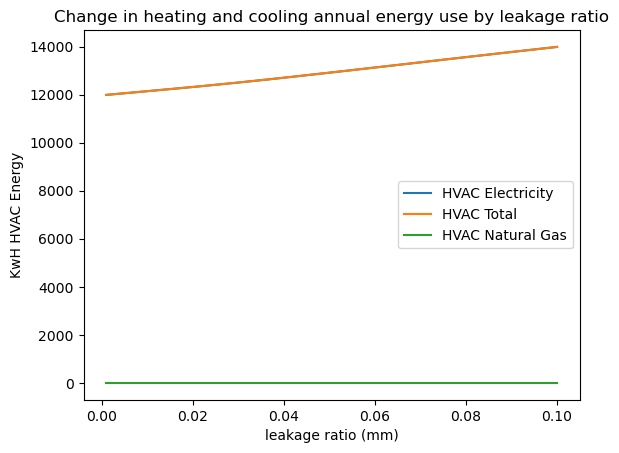

In [479]:
plt.plot(leakageRatioData.index,leakageRatioData['Electricity:HVAC [J](RunPeriod)'],label = "HVAC Electricity")
plt.plot(leakageRatioData.index,leakageRatioData['HP_total_hvac'], label = "HVAC Total")
plt.plot(leakageRatioData.index,leakageRatioData['NaturalGas:HVAC [J](RunPeriod) '],label = "HVAC Natural Gas")
plt.legend()
plt.title("Change in heating and cooling annual energy use by leakage ratio")
plt.xlabel("leakage ratio (mm)")
plt.ylabel("KwH HVAC Energy")

#### Sensitivity Analysis Crack Flow Coefficient 

In [21]:
def changeCrackFlow(idfFile,massFlowCoefficient):
    for i in idfFile.idfobjects["AirflowNetwork:MultiZone:Surface:Crack"]:
        i["Air_Mass_Flow_Coefficient_at_Reference_Conditions"] = massFlowCoefficient

In [482]:
directory  = r"/Applications/EnergyPlus-22-2-0/CCRG_Simulations/crackFlow/"
weatherFile = r"/Applications/EnergyPlus-22-2-0/WeatherData/Chicago5A.epw"
crackFlowData = pd.DataFrame(index =list(np.linspace(0.001,0.07,num = 15)), columns = ['Electricity:Facility [J](RunPeriod)',
                                                                   'Electricity:Building [J](RunPeriod)',
                                                                   'Electricity:HVAC [J](RunPeriod)',
                                                                   'NaturalGas:Facility [J](RunPeriod)',
                                                                   'NaturalGas:HVAC [J](RunPeriod) '])

defaultHouse = r"/Applications/EnergyPlus-22-2-0/ExampleFiles/AirflowNetwork_MultiZone_House_TwoSpeed.idf"

for i in np.linspace(0.001,0.07,num = 15):
    idf1 = IDF(defaultHouse)
    changeCrackFlow(idf1,i)
    idf1.save(r"/Applications/EnergyPlus-22-2-0/ExampleFiles/crack_flow" + str(i) + ".idf")
    
    foldername = str(i)
    houseFile = r"/Applications/EnergyPlus-22-2-0/ExampleFiles/crack_flow" + str(i) + ".idf"
    
    data = runEnergyPlus(directory,foldername,weatherFile,houseFile)
    last_col = data.iloc[-1]
    crackFlowData.loc[i, ['Electricity:Facility [J](RunPeriod)',
                        'Electricity:Building [J](RunPeriod)',
                        'Electricity:HVAC [J](RunPeriod)',
                        'NaturalGas:Facility [J](RunPeriod)',
                        'NaturalGas:HVAC [J](RunPeriod) ']] = list(last_col[5:7]) + list(last_col[8:])
    
    clear_output()
    print(crackFlowData)

         Electricity:Facility [J](RunPeriod)  \
0.001000                  57134952579.400803   
0.005929                  58771173112.118591   
0.010857                  59688830280.600533   
0.015786                  60609564967.611252   
0.020714                  61581122831.078445   
0.025643                  62585778554.947128   
0.030571                  63623739212.323502   
0.035500                  64676284911.862701   
0.040429                  65747458476.527649   
0.045357                  66821065663.345963   
0.050286                  67904436517.559486   
0.055214                  68986054614.097656   
0.060143                  70070581066.424637   
0.065071                  71162802112.163239   
0.070000                   72249174102.00351   

         Electricity:Building [J](RunPeriod) Electricity:HVAC [J](RunPeriod)  \
0.001000                       15764760000.0              41370192579.400963   
0.005929                       15764760000.0              43006413112.1

Text(0, 0.5, 'KwH HVAC Energy')

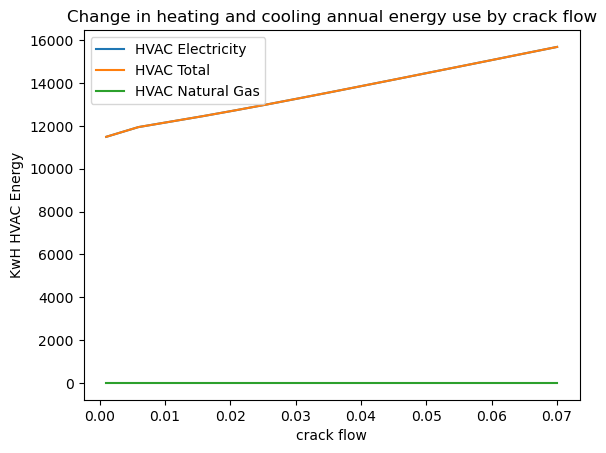

In [483]:
crackFlowData['Electricity:Facility [J](RunPeriod)'] *=  2.777778*10**(-7)
crackFlowData['Electricity:Building [J](RunPeriod)']*=  2.777778*10**(-7)
crackFlowData['Electricity:HVAC [J](RunPeriod)']*=  2.777778*10**(-7)
crackFlowData['NaturalGas:Facility [J](RunPeriod)']*=  2.777778*10**(-7)
crackFlowData['NaturalGas:HVAC [J](RunPeriod) ']*=  2.777778*10**(-7)
crackFlowData['HP_total_hvac'] = crackFlowData['Electricity:HVAC [J](RunPeriod)'] + crackFlowData['NaturalGas:HVAC [J](RunPeriod) ']

plt.plot(crackFlowData.index,crackFlowData['Electricity:HVAC [J](RunPeriod)'],label = "HVAC Electricity")
plt.plot(crackFlowData.index,crackFlowData['HP_total_hvac'], label = "HVAC Total")
plt.plot(crackFlowData.index,crackFlowData['NaturalGas:HVAC [J](RunPeriod) '],label = "HVAC Natural Gas")
plt.legend()
plt.title("Change in heating and cooling annual energy use by crack flow")
plt.xlabel("crack flow")
plt.ylabel("KwH HVAC Energy")

#### Sensitivity Analysis Crack Factor 

In [22]:
def changeCrackFactor(idfFile,crackFactor):
    for i in idfFile.idfobjects["AirflowNetwork:MultiZone:Surface"]:
        #print(i["Surface_Name"])
        i["WindowDoor_Opening_Factor_or_Crack_Factor"] = crackFactor
        

In [493]:
directory  = r"/Applications/EnergyPlus-22-2-0/CCRG_Simulations/crackFactor/"
weatherFile = r"/Applications/EnergyPlus-22-2-0/WeatherData/Chicago5A.epw"
crackFactorData = pd.DataFrame(index =list(np.linspace(0.05,1,num = 15)), columns = ['Electricity:Facility [J](RunPeriod)',
                                                                   'Electricity:Building [J](RunPeriod)',
                                                                   'Electricity:HVAC [J](RunPeriod)',
                                                                   'NaturalGas:Facility [J](RunPeriod)',
                                                                   'NaturalGas:HVAC [J](RunPeriod) '])

defaultHouse = r"/Applications/EnergyPlus-22-2-0/ExampleFiles/AirflowNetwork_MultiZone_House_TwoSpeed.idf"

for i in np.linspace(0.05,1,num = 15):
    idf1 = IDF(defaultHouse)
    changeCrackFactor(idf1,i)
    idf1.save(r"/Applications/EnergyPlus-22-2-0/ExampleFiles/crack_flow" + str(i) + ".idf")
    
    foldername = str(i)
    houseFile = r"/Applications/EnergyPlus-22-2-0/ExampleFiles/crack_flow" + str(i) + ".idf"
    
    data = runEnergyPlus(directory,foldername,weatherFile,houseFile)
    last_col = data.iloc[-1]
    crackFactorData.loc[i, ['Electricity:Facility [J](RunPeriod)',
                        'Electricity:Building [J](RunPeriod)',
                        'Electricity:HVAC [J](RunPeriod)',
                        'NaturalGas:Facility [J](RunPeriod)',
                        'NaturalGas:HVAC [J](RunPeriod) ']] = list(last_col[5:7]) + list(last_col[8:])
    
    clear_output()
    print(crackFactorData)

         Electricity:Facility [J](RunPeriod)  \
0.050000                  57134952579.400803   
0.117857                  57919497984.537689   
0.185714                  58304816254.424362   
0.253571                  58600344952.923897   
0.321429                  58868583367.710251   
0.389286                  59123852402.089066   
0.457143                  59376107278.595322   
0.525000                  59623377639.104332   
0.592857                  59873364461.959953   
0.660714                  60124745067.805977   
0.728571                   60379053514.64859   
0.796429                  60638036868.883186   
0.864286                  60899966863.110764   
0.932143                  61167521295.181015   
1.000000                  61438928260.340012   

         Electricity:Building [J](RunPeriod) Electricity:HVAC [J](RunPeriod)  \
0.050000                       15764760000.0              41370192579.400963   
0.117857                       15764760000.0               42154737984.

Text(0, 0.5, 'KwH HVAC Energy')

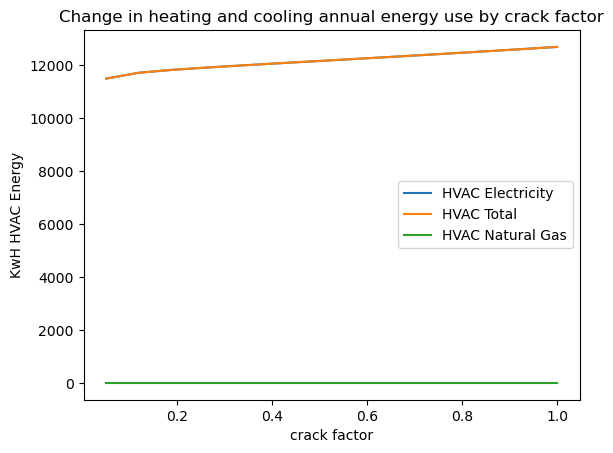

In [494]:
crackFactorData['Electricity:Facility [J](RunPeriod)'] *=  2.777778*10**(-7)
crackFactorData['Electricity:Building [J](RunPeriod)']*=  2.777778*10**(-7)
crackFactorData['Electricity:HVAC [J](RunPeriod)']*=  2.777778*10**(-7)
crackFactorData['NaturalGas:Facility [J](RunPeriod)']*=  2.777778*10**(-7)
crackFactorData['NaturalGas:HVAC [J](RunPeriod) ']*=  2.777778*10**(-7)
crackFactorData['HP_total_hvac'] = crackFactorData['Electricity:HVAC [J](RunPeriod)'] + crackFactorData['NaturalGas:HVAC [J](RunPeriod) ']

plt.plot(crackFactorData.index,crackFactorData['Electricity:HVAC [J](RunPeriod)'],label = "HVAC Electricity")
plt.plot(crackFactorData.index,crackFactorData['HP_total_hvac'], label = "HVAC Total")
plt.plot(crackFactorData.index,crackFactorData['NaturalGas:HVAC [J](RunPeriod) '],label = "HVAC Natural Gas")
plt.legend()
plt.title("Change in heating and cooling annual energy use by crack factor")
plt.xlabel("crack factor")
plt.ylabel("KwH HVAC Energy")

#### Duct Size Sensitivity Analysis for small House

In [456]:
directory  = r"/Applications/EnergyPlus-22-2-0/CCRG_Simulations/ductSizeSensitivity/"
weatherFile = r"/Applications/EnergyPlus-22-2-0/WeatherData/Chicago5A.epw"
ductSizeData = pd.DataFrame(index =list(np.linspace(0.15,1,num = 7)), columns = ['Electricity:Facility [J](RunPeriod)',
                                                                   'Electricity:Building [J](RunPeriod)',
                                                                   'Electricity:HVAC [J](RunPeriod)',
                                                                   'NaturalGas:Facility [J](RunPeriod)',
                                                                   'NaturalGas:HVAC [J](RunPeriod) '])

defaultHouse = r"/Applications/EnergyPlus-22-2-0/ExampleFiles/AirflowNetwork_MultiZone_House_TwoSpeed.idf"

for i in np.linspace(0.15,1,num = 7):
    idf1 = IDF(defaultHouse)
    updateSQFT(idf1,400)
    
    for duct in idf1.idfobjects["AirflowNetwork:Distribution:Component:Duct"]:
        duct['Cross_Section_Area'] = duct['Cross_Section_Area'] * i

    idf1.save(r"/Applications/EnergyPlus-22-2-0/ExampleFiles/ductSize" + str(i) + ".idf")
    foldername = str(i)
    houseFile = r"/Applications/EnergyPlus-22-2-0/ExampleFiles/ductSize" + str(i) + ".idf"
    
    data = runEnergyPlus(directory,foldername,weatherFile,houseFile)
    last_col = data.iloc[-1]
    ductSizeData.loc[i, ['Electricity:Facility [J](RunPeriod)',
                        'Electricity:Building [J](RunPeriod)',
                        'Electricity:HVAC [J](RunPeriod)',
                        'NaturalGas:Facility [J](RunPeriod)',
                        'NaturalGas:HVAC [J](RunPeriod) ']] = list(last_col[5:7]) + list(last_col[8:])
    
    clear_output()
    print(ductSizeData)

         Electricity:Facility [J](RunPeriod)  \
0.150000                  32083152755.487404   
0.291667                  30374089206.249096   
0.433333                  29844135906.112282   
0.575000                   29598364911.57494   
0.716667                  29460183043.121197   
0.858333                  29375940272.101704   
1.000000                  29321627241.853851   

         Electricity:Building [J](RunPeriod) Electricity:HVAC [J](RunPeriod)  \
0.150000                       15764760000.0              16318392755.487757   
0.291667                       15764760000.0              14609329206.248898   
0.433333                       15764760000.0              14079375906.112305   
0.575000                       15764760000.0              13833604911.575024   
0.716667                       15764760000.0               13695423043.12134   
0.858333                       15764760000.0              13611180272.102039   
1.000000                       15764760000.0           

In [457]:
ductSizeData['Electricity:Facility [J](RunPeriod)'] *=  2.777778*10**(-7)
ductSizeData['Electricity:Building [J](RunPeriod)']*=  2.777778*10**(-7)
ductSizeData['Electricity:HVAC [J](RunPeriod)']*=  2.777778*10**(-7)
ductSizeData['NaturalGas:Facility [J](RunPeriod)']*=  2.777778*10**(-7)
ductSizeData['NaturalGas:HVAC [J](RunPeriod) ']*=  2.777778*10**(-7)
ductSizeData['HP_total_hvac'] = ductSizeData['Electricity:HVAC [J](RunPeriod)'] + ductSizeData['NaturalGas:HVAC [J](RunPeriod) ']

Text(0, 0.5, 'KwH HVAC Energy')

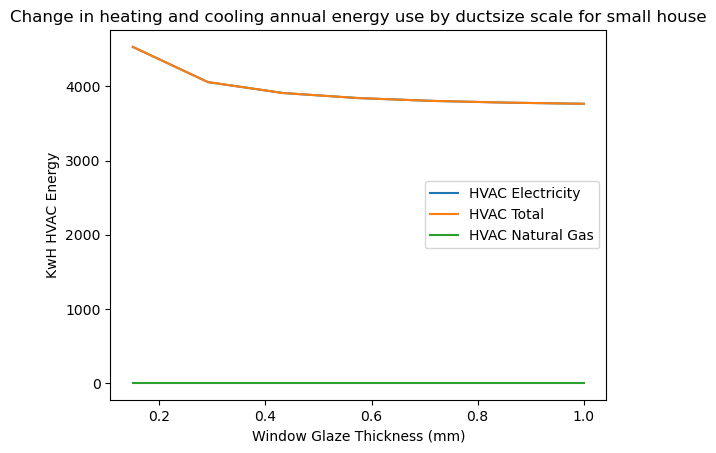

In [458]:
plt.plot(ductSizeData.index,ductSizeData['Electricity:HVAC [J](RunPeriod)'],label = "HVAC Electricity")
plt.plot(ductSizeData.index,ductSizeData['HP_total_hvac'], label = "HVAC Total")
plt.plot(ductSizeData.index,ductSizeData['NaturalGas:HVAC [J](RunPeriod) '],label = "HVAC Natural Gas")
plt.legend()
plt.title("Change in heating and cooling annual energy use by ductsize scale for small house")
plt.xlabel("Window Glaze Thickness (mm)")
plt.ylabel("KwH HVAC Energy")

#### Adjust COP Functions

In [23]:
def getHeatingCop(HVAC_description):
    return int(HVAC_description[11:13]) * 1055/3600

def updateCop(idfFile, HVAC_description):
    COP = getHeatingCop(HVAC_description)
    idfFile.idfobjects['Coil:Heating:DX:MultiSpeed'][0]['Speed_1_Gross_Rated_Heating_COP'] = COP
    idfFile.idfobjects['Coil:Heating:DX:MultiSpeed'][0]['Speed_2_Gross_Rated_Heating_COP'] = COP + 0.25

#### Sanity Check Simulation for California Heat Pump Houses

In [339]:
CA_heatpump_metadata = CA_metadata.loc[(CA_metadata['in.hvac_heating_type_and_fuel'] == "Electricity ASHP") & (CA_metadata['in.hvac_cooling_type'] == "Heat Pump")]

CA_heatpump_metadata['Electricity:Facility [J](RunPeriod)'] = list(np.zeros(CA_heatpump_metadata.shape[0]))
CA_heatpump_metadata['Electricity:Building [J](RunPeriod)'] = list(np.zeros(CA_heatpump_metadata.shape[0]))
CA_heatpump_metadata['Electricity:HVAC [J](RunPeriod)'] = list(np.zeros(CA_heatpump_metadata.shape[0]))
CA_heatpump_metadata['NaturalGas:Facility [J](RunPeriod)'] = list(np.zeros(CA_heatpump_metadata.shape[0]))
CA_heatpump_metadata['NaturalGas:HVAC [J](RunPeriod) '] = list(np.zeros(CA_heatpump_metadata.shape[0]))

#update cooling and heating setpoints
directory  = r"/Applications/EnergyPlus-22-2-0/CCRG_Simulations/Heatpump_Sanity_Check/"
defaultHouse = r"/Applications/EnergyPlus-22-2-0/ExampleFiles/AirflowNetwork_MultiZone_House_TwoSpeed.idf"
weatherDir = r"/Users/kyan/opt/anaconda3/lib/python3.9/site-packages/diyepw/data/tmy_epw_files/"

i = 1
for index, house in CA_heatpump_metadata.iloc[:].iterrows():
    if i > 100: break
    idfFile = IDF(defaultHouse)
    
    idfFile.idfobjects["WindowMaterial:Gas"][0]['Thickness'] = 0.005
    updateSchedule(idfFile, house['in.cooling_setpoint'],house['in.cooling_setpoint_offset_magnitude'],house['in.cooling_setpoint_offset_period'],house['in.heating_setpoint'],house['in.heating_setpoint_offset_magnitude'],house['in.heating_setpoint_offset_period'])
    updateSQFT(idfFile,house['in.sqft'])
    updateLeakageRatio(idfFile, house['in.ducts']) 
    updateCop(idfFile,house['in.hvac_heating_efficiency'])
        
    idfFile.save(r"/Applications/EnergyPlus-22-2-0/ExampleFiles/heatpump_sanity_check_" + str(index) + ".idf")
    
    foldername = str(index)
    houseFile = r"/Applications/EnergyPlus-22-2-0/ExampleFiles/heatpump_sanity_check_" + str(index) + ".idf"
    
    weatherFile = weatherDir + countiesLatsLons.loc[countiesLatsLons.index == house['FIPS']]['path1']
    data = runEnergyPlus(directory,foldername,weatherFile,houseFile)
    last_col = data.iloc[-1]
    
    CA_heatpump_metadata.loc[index, ['Electricity:Facility [J](RunPeriod)',
                        'Electricity:Building [J](RunPeriod)',
                        'Electricity:HVAC [J](RunPeriod)',
                        'NaturalGas:Facility [J](RunPeriod)',
                        'NaturalGas:HVAC [J](RunPeriod) ']] = list(last_col[5:7]) + list(last_col[8:])
    clear_output()
    print(CA_heatpump_metadata.head(i))
    i+=1

In [ ]:
CA_heatpump_metadata['Electricity:Facility [J](RunPeriod)'] *=  2.777778*10**(-7)
CA_heatpump_metadata['Electricity:Building [J](RunPeriod)']*=  2.777778*10**(-7)
CA_heatpump_metadata['Electricity:HVAC [J](RunPeriod)']*=  2.777778*10**(-7)
CA_heatpump_metadata['NaturalGas:Facility [J](RunPeriod)']*=  2.777778*10**(-7)
CA_heatpump_metadata['NaturalGas:HVAC [J](RunPeriod) ']*=  2.777778*10**(-7)
CA_heatpump_metadata['HP_total_hvac'] = CA_heatpump_metadata['Electricity:HVAC [J](RunPeriod)'] + CA_heatpump_metadata['NaturalGas:HVAC [J](RunPeriod) ']
CA_heatpump_metadata.to_csv("CA_heatpump_metadata_simulation")

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user

#### Sanity Check Plot Validation CA

In [196]:
CA_heatpump_simulation = CA_heatpump_metadata.iloc[1:100]
CA_heatpump_simulation['total_hvac'] = get_total_HVAC(CA_heatpump_simulation)

CA_heatpump_simulation['total_electricity'] = CA_heatpump_simulation['out.electricity.cooling.energy_consumption.kwh'] + CA_heatpump_simulation['out.electricity.heating.energy_consumption.kwh']
CA_heatpump_simulation['COP'] = [int(item[11:13])* 1055/3600 for item in list(CA_heatpump_simulation['in.hvac_heating_efficiency'])]
CA_heatpump_simulation['ductLeakage'] = [getLeakageRatio(item) for item in list(CA_heatpump_simulation['in.ducts'])]

#CA_heatpump_simulation.iloc[-1]
CA_heatpump_simulation = CA_heatpump_simulation.sort_values(by = ['in.sqft'])
#CA_heatpump_simulation['in.cooling_setpoint']

x = list(range(0,len(CA_heatpump_simulation.index)))
plt.plot(x,CA_heatpump_simulation['total_electricity'],label = "real")
plt.plot(x,CA_heatpump_simulation['Electricity:HVAC [J](RunPeriod)'],label = "simulated")
plt.ylim([0,20000])
plt.legend()
plt.title("real vs simulated over sqft")

NameError: name 'CA_heatpump_metadata' is not defined

In [513]:
print("ResStock median electricity HVAC:", np.median(CA_heatpump_simulation['total_electricity']))
print("Simulation median electricity HVAC:", np.median(CA_heatpump_simulation['Electricity:HVAC [J](RunPeriod)']))

ResStock median electricity HVAC: 2559.9757964500004
Simulation median electricity HVAC: 5044.02162119717


#### Illinois Sanity Check

In [24]:
US_metadata = pd.read_parquet('baseline_metadata_and_annual_results.parquet')
IL_metadata = US_metadata.loc[US_metadata['in.state'] == 'IL']
newCounty = [county[1:3] + county[4:7] for county in IL_metadata['in.county']]
IL_metadata['FIPS'] = newCounty

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [25]:
IL_heatpump_metadata = IL_metadata.loc[(IL_metadata['in.hvac_heating_type_and_fuel'] == "Electricity ASHP") & (IL_metadata['in.hvac_cooling_type'] == "Heat Pump")]

cooling_setpoints = [int(setpointString[:-1]) for setpointString in list(IL_heatpump_metadata['in.cooling_setpoint']) ]
IL_heatpump_metadata['in.cooling_setpoint'] = cooling_setpoints

heating_setpoints = [int(setpointString[:-1]) for setpointString in list(IL_heatpump_metadata['in.heating_setpoint']) ]
IL_heatpump_metadata['in.heating_setpoint'] = heating_setpoints

cooling_offsets = [int(setpointString[:-1]) for setpointString in list(IL_heatpump_metadata['in.cooling_setpoint_offset_magnitude']) ]
IL_heatpump_metadata['in.cooling_setpoint_offset_magnitude'] = cooling_offsets

heating_offsets = [int(setpointString[:-1]) for setpointString in list(IL_heatpump_metadata['in.heating_setpoint_offset_magnitude']) ]
IL_heatpump_metadata['in.heating_setpoint_offset_magnitude'] = heating_offsets

IL_heatpump_metadata['Electricity:Facility [J](RunPeriod)'] = list(np.zeros(IL_heatpump_metadata.shape[0]))
IL_heatpump_metadata['Electricity:Building [J](RunPeriod)'] = list(np.zeros(IL_heatpump_metadata.shape[0]))
IL_heatpump_metadata['Electricity:HVAC [J](RunPeriod)'] = list(np.zeros(IL_heatpump_metadata.shape[0]))
IL_heatpump_metadata['NaturalGas:Facility [J](RunPeriod)'] = list(np.zeros(IL_heatpump_metadata.shape[0]))
IL_heatpump_metadata['NaturalGas:HVAC [J](RunPeriod) '] = list(np.zeros(IL_heatpump_metadata.shape[0]))

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user

In [459]:
#update cooling and heating setpoints
directory  = r"/Applications/EnergyPlus-22-2-0/CCRG_Simulations/Heatpump_Sanity_Check/"
defaultHouse = r"/Applications/EnergyPlus-22-2-0/ExampleFiles/AirflowNetwork_MultiZone_House_TwoSpeed.idf"
weatherDir = r"/Users/kyan/opt/anaconda3/lib/python3.9/site-packages/diyepw/data/tmy_epw_files/"

i = 1
for index, house in IL_heatpump_metadata.iloc[:].iterrows():
    if i > 75: break
    idfFile = IDF(defaultHouse)
    
    idfFile.idfobjects["WindowMaterial:Gas"][0]['Thickness'] = 0.005
    updateSchedule(idfFile, house['in.cooling_setpoint'],house['in.cooling_setpoint_offset_magnitude'],house['in.cooling_setpoint_offset_period'],house['in.heating_setpoint'],house['in.heating_setpoint_offset_magnitude'],house['in.heating_setpoint_offset_period'])
    updateSQFT(idfFile,house['in.sqft'])
    updateLeakageRatio(idfFile, house['in.ducts'])
    updateCop(idfFile,house['in.hvac_heating_efficiency'])
        
    idfFile.save(r"/Applications/EnergyPlus-22-2-0/ExampleFiles/heatpump_sanity_check_" + str(index) + ".idf")
    
    foldername = str(index)
    houseFile = r"/Applications/EnergyPlus-22-2-0/ExampleFiles/heatpump_sanity_check_" + str(index) + ".idf"
    
    weatherFile = weatherDir + countiesLatsLons.loc[countiesLatsLons.index == house['FIPS']]['path1']
    data = runEnergyPlus(directory,foldername,weatherFile,houseFile)
    last_col = data.iloc[-1]
    
    IL_heatpump_metadata.loc[index, ['Electricity:Facility [J](RunPeriod)',
                        'Electricity:Building [J](RunPeriod)',
                        'Electricity:HVAC [J](RunPeriod)',
                        'NaturalGas:Facility [J](RunPeriod)',
                        'NaturalGas:HVAC [J](RunPeriod) ']] = list(last_col[5:7]) + list(last_col[8:])
    clear_output()
    print(IL_heatpump_metadata.head(i))
    i+=1

         upgrade      weight  applicability  in.sqft  \
bldg_id                                                
493            0  242.131013           True    885.0   
825            0  242.131013           True    853.0   
853            0  242.131013           True   1675.0   
1817           0  242.131013           True   8194.0   
1921           0  242.131013           True   2115.0   
...          ...         ...            ...      ...   
50237          0  242.131013           True   1220.0   
50626          0  242.131013           True   1138.0   
51451          0  242.131013           True    333.0   
52215          0  242.131013           True   2176.0   
53036          0  242.131013           True   1138.0   

                                   in.ahs_region  \
bldg_id                                            
493                  Non-CBSA East North Central   
825      CBSA Chicago-Naperville-Elgin, IL-IN-WI   
853      CBSA Chicago-Naperville-Elgin, IL-IN-WI   
1817       

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user

Text(0.5, 1.0, 'real vs simulated over sqft')

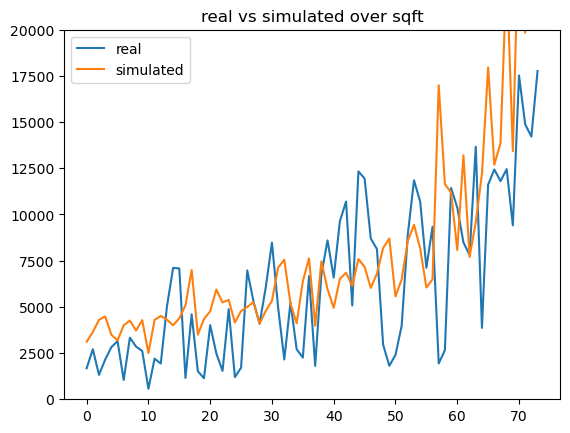

In [460]:
IL_heatpump_metadata['Electricity:Facility [J](RunPeriod)'] *=  2.777778*10**(-7)
IL_heatpump_metadata['Electricity:Building [J](RunPeriod)']*=  2.777778*10**(-7)
IL_heatpump_metadata['Electricity:HVAC [J](RunPeriod)']*=  2.777778*10**(-7)
IL_heatpump_metadata['NaturalGas:Facility [J](RunPeriod)']*=  2.777778*10**(-7)
IL_heatpump_metadata['NaturalGas:HVAC [J](RunPeriod) ']*=  2.777778*10**(-7)
IL_heatpump_metadata['HP_total_hvac'] = IL_heatpump_metadata['Electricity:HVAC [J](RunPeriod)'] + IL_heatpump_metadata['NaturalGas:HVAC [J](RunPeriod) ']
IL_heatpump_metadata.to_csv("IL_heatpump_metadata_simulation.csv")

IL_heatpump_simulation = IL_heatpump_metadata.iloc[1:75]
IL_heatpump_simulation['total_hvac'] = IL_heatpump_simulation['out.electricity.cooling.energy_consumption.kwh'] + IL_heatpump_simulation['out.electricity.heating.energy_consumption.kwh'] + IL_heatpump_simulation['out.fuel_oil.heating.energy_consumption.kwh'] + IL_heatpump_simulation['out.natural_gas.heating.energy_consumption.kwh'] + IL_heatpump_simulation['out.propane.heating.energy_consumption.kwh']
IL_heatpump_simulation['total_electricity'] = IL_heatpump_simulation['out.electricity.cooling.energy_consumption.kwh'] + IL_heatpump_simulation['out.electricity.heating.energy_consumption.kwh']
IL_heatpump_simulation['COP'] = [int(item[11:13])* 1055/3600 for item in list(IL_heatpump_simulation['in.hvac_heating_efficiency'])]
IL_heatpump_simulation['ductLeakage'] = [getLeakageRatio(item) for item in list(IL_heatpump_simulation['in.ducts'])]

Text(0.5, 1.0, 'real vs simulated over sqft')

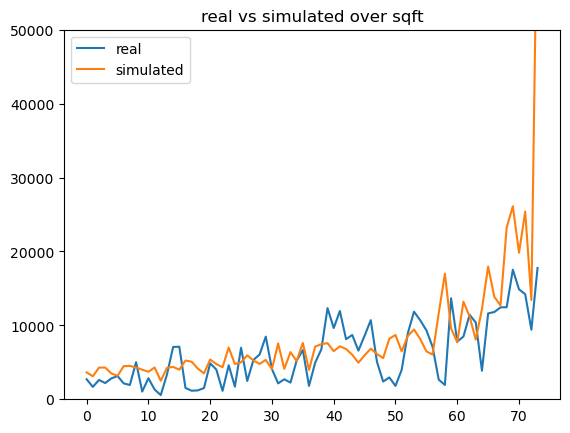

In [470]:
#CA_heatpump_simulation.iloc[-1]
IL_heatpump_simulation = IL_heatpump_simulation.sort_values(by = ['in.sqft'])
#CA_heatpump_simulation['in.cooling_setpoint']

x = list(range(0,len(IL_heatpump_simulation.index)))
plt.plot(x,IL_heatpump_simulation['total_electricity'],label = "real")
plt.plot(x,IL_heatpump_simulation['Electricity:HVAC [J](RunPeriod)'],label = "simulated")
plt.ylim([0,50000])
plt.legend()
plt.title("real vs simulated over sqft")

In [514]:
print("ResStock median electricity HVAC:", np.median(IL_heatpump_simulation['total_electricity']))
print("Simulation median electricity HVAC:", np.median(IL_heatpump_simulation['Electricity:HVAC [J](RunPeriod)']))


ResStock median electricity HVAC: 5045.658076655
Simulation median electricity HVAC: 6037.339431387955


#### Illinois Heat Pump Sanity Check no leakage

In [146]:
IL_heatpump_metadata_noleaks = IL_heatpump_metadata
IL_heatpump_metadata_noleaks['Electricity:Facility [J](RunPeriod)'] = list(np.zeros(IL_heatpump_metadata_noleaks.shape[0]))
IL_heatpump_metadata_noleaks['Electricity:Building [J](RunPeriod)'] = list(np.zeros(IL_heatpump_metadata_noleaks.shape[0]))
IL_heatpump_metadata_noleaks['Electricity:HVAC [J](RunPeriod)'] = list(np.zeros(IL_heatpump_metadata_noleaks.shape[0]))
IL_heatpump_metadata_noleaks['NaturalGas:Facility [J](RunPeriod)'] = list(np.zeros(IL_heatpump_metadata_noleaks.shape[0]))
IL_heatpump_metadata_noleaks['NaturalGas:HVAC [J](RunPeriod) '] = list(np.zeros(IL_heatpump_metadata_noleaks.shape[0]))
#IL_heatpump_metadata_noleaks['total_hvac'] = IL_heatpump_metadata_noleaks['out.electricity.cooling.energy_consumption.kwh'] + IL_heatpump_metadata_noleaks['out.electricity.heating.energy_consumption.kwh'] + IL_heatpump_metadata_noleaks['out.fuel_oil.heating.energy_consumption.kwh'] + IL_heatpump_metadata_noleaks['out.natural_gas.heating.energy_consumption.kwh'] + IL_heatpump_metadata_noleaks['out.propane.heating.energy_consumption.kwh']


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user

In [123]:
#update cooling and heating setpoints
directory  = r"/Applications/EnergyPlus-22-2-0/CCRG_Simulations/Heatpump_Sanity_Check_noleaks/"
defaultHouse = r"/Applications/EnergyPlus-22-2-0/ExampleFiles/AirflowNetwork_MultiZone_House_TwoSpeed.idf"
weatherDir = r"/Users/kyan/opt/anaconda3/lib/python3.9/site-packages/diyepw/data/tmy_epw_files/"

i = 1
for index, house in IL_heatpump_metadata_noleaks.iloc[:].iterrows():
    if i > 75: break
    idfFile = IDF(defaultHouse)
    
    idfFile.idfobjects["WindowMaterial:Gas"][0]['Thickness'] = 0.005
    updateSchedule(idfFile, house['in.cooling_setpoint'],house['in.cooling_setpoint_offset_magnitude'],house['in.cooling_setpoint_offset_period'],house['in.heating_setpoint'],house['in.heating_setpoint_offset_magnitude'],house['in.heating_setpoint_offset_period'])
    updateSQFT(idfFile,house['in.sqft'])
    changeLeakageRatio(idfFile, 0.0001)
    changeCrackFlow(idfFile, 0.0001)
    changeCrackFactor(idfFile, 0.01)
    updateLeakageRatio(idfFile, house['in.ducts'])
    updateCop(idfFile,house['in.hvac_heating_efficiency'])

    idfFile.save(r"/Applications/EnergyPlus-22-2-0/ExampleFiles/heatpump_sanity_check_" + str(index) + ".idf")
    
    foldername = str(index)
    houseFile = r"/Applications/EnergyPlus-22-2-0/ExampleFiles/heatpump_sanity_check_" + str(index) + ".idf"
    
    weatherFile = weatherDir + countiesLatsLons.loc[countiesLatsLons.index == house['FIPS']]['path1']
    data = runEnergyPlus(directory,foldername,weatherFile,houseFile)
    last_col = data.iloc[-1]
    
    IL_heatpump_metadata_noleaks.loc[index, ['Electricity:Facility [J](RunPeriod)',
                        'Electricity:Building [J](RunPeriod)',
                        'Electricity:HVAC [J](RunPeriod)',
                        'NaturalGas:Facility [J](RunPeriod)',
                        'NaturalGas:HVAC [J](RunPeriod) ']] = list(last_col[5:7]) + list(last_col[8:])
    clear_output()
    print(IL_heatpump_metadata_noleaks.head(i))
    i+=1

         upgrade      weight  applicability  in.sqft  \
bldg_id                                                
493            0  242.131013           True    885.0   
825            0  242.131013           True    853.0   

                                   in.ahs_region  \
bldg_id                                            
493                  Non-CBSA East North Central   
825      CBSA Chicago-Naperville-Elgin, IL-IN-WI   

        in.ashrae_iecc_climate_zone_2004  \
bldg_id                                    
493                                   4A   
825                                   5A   

        in.ashrae_iecc_climate_zone_2004_2_a_split in.bathroom_spot_vent_hour  \
bldg_id                                                                         
493                                             4A                     Hour21   
825                                             5A                     Hour20   

        in.bedrooms in.building_america_climate_zone  ...  \
bld

KeyboardInterrupt: 

In [197]:
IL_heatpump_metadata_noleaks['Electricity:Facility [J](RunPeriod)'] *=  2.777778*10**(-7)
IL_heatpump_metadata_noleaks['Electricity:Building [J](RunPeriod)']*=  2.777778*10**(-7)
IL_heatpump_metadata_noleaks['Electricity:HVAC [J](RunPeriod)']*=  2.777778*10**(-7)
IL_heatpump_metadata_noleaks['NaturalGas:Facility [J](RunPeriod)']*=  2.777778*10**(-7)
IL_heatpump_metadata_noleaks['NaturalGas:HVAC [J](RunPeriod) ']*=  2.777778*10**(-7)
IL_heatpump_metadata_noleaks['HP_total_hvac'] = IL_heatpump_metadata_noleaks['Electricity:HVAC [J](RunPeriod)'] + IL_heatpump_metadata_noleaks['NaturalGas:HVAC [J](RunPeriod) ']
IL_heatpump_metadata_noleaks.to_csv("IL_heatpump_metadata_simulation_noleaks.csv")

IL_heatpump_simulation_noleaks = IL_heatpump_metadata_noleaks.iloc[1:150]
IL_heatpump_simulation_noleaks['total_hvac'] = get_total_HVAC(IL_heatpump_simulation_noleaks)
IL_heatpump_simulation_noleaks['total_electricity'] = IL_heatpump_simulation_noleaks['out.electricity.cooling.energy_consumption.kwh'] + IL_heatpump_simulation_noleaks['out.electricity.heating.energy_consumption.kwh']
IL_heatpump_simulation_noleaks['COP'] = [int(item[11:13])* 1055/3600 for item in list(IL_heatpump_simulation_noleaks['in.hvac_heating_efficiency'])]
IL_heatpump_simulation_noleaks['ductLeakage'] = [getLeakageRatio(item) for item in list(IL_heatpump_simulation_noleaks['in.ducts'])]

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user

ResStock median HVAC: 6577.9801661500005
Simulation median HVAC: 0.0


Text(0.5, 1.0, 'real vs simulated over sqft')

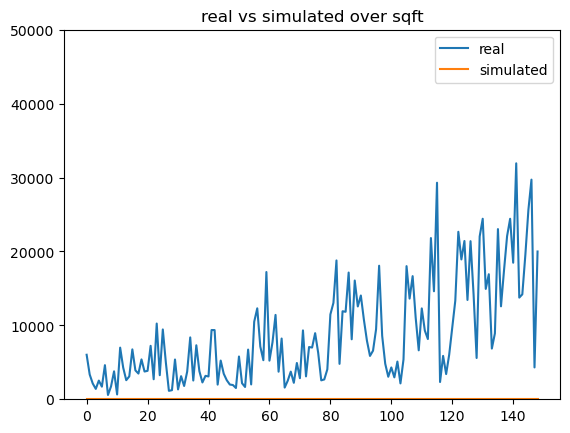

In [198]:
#CA_heatpump_simulation.iloc[-1]
IL_heatpump_simulation_noleaks = IL_heatpump_simulation_noleaks.sort_values(by = ['in.sqft'])

print("ResStock median HVAC:", np.median(IL_heatpump_simulation_noleaks['total_hvac']))
print("Simulation median HVAC:", np.median(IL_heatpump_simulation_noleaks['HP_total_hvac']))

x = list(range(0,len(IL_heatpump_simulation_noleaks.index)))
plt.plot(x,IL_heatpump_simulation_noleaks['total_hvac'],label = "real")
plt.plot(x,IL_heatpump_simulation_noleaks['HP_total_hvac'],label = "simulated")
plt.ylim([0,50000])
plt.legend()
plt.title("real vs simulated over sqft")

In [516]:
print("ResStock median electricity HVAC:", np.median(IL_heatpump_simulation_noleaks['total_hvac']))
print("Simulation median electricity HVAC:", np.median(IL_heatpump_simulation_noleaks['HP_total_hvac']))

ResStock median electricity HVAC: 5045.658076655
Simulation median electricity HVAC: 4960.574363952692


In [234]:
print("ResStock mean electricity HVAC:", np.mean(IL_heatpump_simulation_noleaks['total_hvac']))
print("Simulation mean electricity HVAC:", np.mean(IL_heatpump_simulation_noleaks['HP_total_hvac']))

ResStock mean electricity HVAC: 8710.314131551746
Simulation mean electricity HVAC: 0.0


### HVAC Cases:
1. Natural Gas Furnace with no cooling (%4.847)
2. Natural Gas Furnace with centralized AC (%24.55)
3. Natural Gas Furnace with room AC (%3.67)

#### Sensitivity Analysis Furnace outlet temp

In [ ]:
#function to change outlet temp of file

In [284]:
#base weather and furnace file
directory  = r"/Applications/EnergyPlus-22-2-0/CCRG_Simulations/outlet_temp_sensitivity_analysis/"
defaultHouse = r"/Applications/EnergyPlus-22-2-0/ExampleFiles/furnace_simulation_template.idf"
weatherFile = r"/Applications/EnergyPlus-22-2-0/WeatherData/Chicago5A.epw"

outputVariables = ['Electricity:Facility [J](RunPeriod)',
                                                                   'Electricity:Building [J](RunPeriod)',
                                                                   'Electricity:HVAC [J](RunPeriod)',
                                                                   'NaturalGas:Facility [J](RunPeriod)',
                                                                   'NaturalGas:HVAC [J](RunPeriod)']

ductSizeData = pd.DataFrame(index =list(np.linspace(0.1,20,num = 30)), columns = outputVariables)

In [285]:
#loop through outlet temp differentials
i = 1
for outletTemp in list(np.linspace(0.1,20,num = 30)):
    idfFile = IDF(defaultHouse)
    
    fuel = "NaturalGas"
    furnacetype = "Fuel Furnace, 92.5% AFUE"
    coolingEfficiency = "AC, SEER 15"
    
    createFurnaceCentralAC(idfFile, fuel, coolingEfficiency, furnacetype,"Air Loop Inlet Node", "Air Loop Outlet Node",22, outletTemp)
    
    idfFile.idfobjects["WindowMaterial:Gas"][0]['Thickness'] = 0.005
    changeLeakageRatio(idfFile, 0.0001)
    changeCrackFlow(idfFile, 0.0001)
    changeCrackFactor(idfFile, 0.01)

    idfFile.save(r"/Applications/EnergyPlus-22-2-0/ExampleFiles/outlet_temp_sensitivity_analysis_" + str(outletTemp) + ".idf")
    
    foldername = str(outletTemp)
    houseFile = r"/Applications/EnergyPlus-22-2-0/ExampleFiles/outlet_temp_sensitivity_analysis_" + str(outletTemp) + ".idf"
    #weatherFile= r"/Applications/EnergyPlus-22-2-0/WeatherData/Chicago5A.epw"
    data = runEnergyPlus(directory,foldername,weatherFile,houseFile)
    last_col = data.iloc[-1]
    clear_output()
    
    for outputVariable in outputVariables:
        try: 
            ductSizeData.loc[outletTemp, outputVariable] = last_col[outputVariable]
        except Exception as e:
            try:
                ductSizeData.loc[outletTemp, outputVariable] = last_col[outputVariable + ' ']
            except Exception as e:
                pass
    print(ductSizeData.head(i))
    i+=1

          Electricity:Facility [J](RunPeriod)  \
0.100000                   47953483045.436005   
0.786207                   43302893533.303261   
1.472414                   38493286086.975647   
2.158621                   34890845793.220642   
2.844828                   32540941235.048351   
3.531034                    30972310892.54147   
4.217241                   29874605095.217587   
4.903448                   29065638207.203304   
5.589655                   28445066332.790081   
6.275862                   27953797249.564339   
6.962069                   27555054606.680328   
7.648276                   27225068476.830582   
8.334483                   26947294688.280952   
9.020690                   26710438607.747711   
9.706897                      26506076934.104   
10.393103                  26328018249.396198   
11.079310                  26171318616.145782   
11.765517                  26032631941.431744   
12.451724                   25908410689.18541   
13.137931           

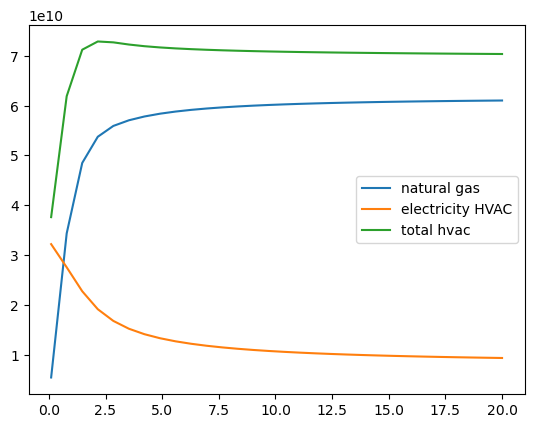

In [289]:
#nductSizeData = ductSizeData.loc[0:30]
plt.plot(nductSizeData.index, nductSizeData['NaturalGas:HVAC [J](RunPeriod)'], label = "natural gas" )
plt.plot(nductSizeData.index, nductSizeData['Electricity:HVAC [J](RunPeriod)'], label =  "electricity HVAC")
plt.plot(nductSizeData.index, nductSizeData['NaturalGas:HVAC [J](RunPeriod)'] + nductSizeData['Electricity:HVAC [J](RunPeriod)'], label =  "total hvac")    
plt.legend()

#### furnace centralized AC

##### createFurnaceCentralizedAC Function, including creating coils

In [171]:
def getFurnaceEfficiency(description):
    return float(description.split(", ")[1].split("%")[0])/100

def createFurnaceCoil(idfFile, name, fuel, typedescription,inletName, outletName):
    if fuel == "Electricity":
        x = idfFile.newidfobject('Coil:Heating:Electric')
        x['Name'] = name
        x['Availability_Schedule_Name'] = "HVACAvailSched"
        x['Efficiency'] = getFurnaceEfficiency(typedescription)
        x['Nominal_Capacity'] = 'autosize'
        x['Air_Inlet_Node_Name'] = inletName
        x['Air_Outlet_Node_Name'] = outletName
    else:
        x = idfFile.newidfobject("Coil:Heating:Fuel")
        x['Availability_Schedule_Name'] = "HVACAvailSched"
        x['Name'] = name
        x["Fuel_Type"] = fuel
        x['Burner_Efficiency'] = getFurnaceEfficiency(typedescription)
        x['Nominal_Capacity'] = 'autosize'
        x['Air_Inlet_Node_Name'] = inletName
        x['Air_Outlet_Node_Name'] = outletName
        
def getCoolingEfficiency(efficiency_description):
    if efficiency_description == "Shared Cooling": return 12.0
    return float(efficiency_description.split("SEER")[1])

def createCoolingCoil(idfFile, name, efficiency_description, inletName,outletName):
    coolingCoil = idfFile.newidfobject("Coil:Cooling:DX:SingleSpeed")
    coolingCoil['Availability_Schedule_Name'] = "HVACAvailSched"
    coolingCoil['Name'] = name
    coolingCoil['Gross_Rated_Total_Cooling_Capacity'] = 'autosize'
    coolingCoil['Gross_Rated_Sensible_Heat_Ratio'] = 'autosize'
    coolingCoil['Gross_Rated_Cooling_COP'] = getCoolingEfficiency(efficiency_description) * 1055/3600
    coolingCoil['Rated_Air_Flow_Rate'] = 'autosize'
    coolingCoil['Air_Inlet_Node_Name'] = inletName
    coolingCoil['Air_Outlet_Node_Name'] = outletName
    coolingCoil['Total_Cooling_Capacity_Function_of_Temperature_Curve_Name'] = 'HPACCoolCapFT Speed 1'
    coolingCoil['Total_Cooling_Capacity_Function_of_Flow_Fraction_Curve_Name'] = 'HPACCoolCapFF Speed 1'
    coolingCoil['Energy_Input_Ratio_Function_of_Temperature_Curve_Name'] = 'HPACCoolEIRFT Speed 1'
    coolingCoil['Energy_Input_Ratio_Function_of_Flow_Fraction_Curve_Name'] = 'HPACCoolEIRFF Speed 1'
    coolingCoil['Part_Load_Fraction_Correlation_Curve_Name'] = 'HPACCoolPLFFPLR Speed 1'
    coolingCoil['Nominal_Time_for_Condensate_Removal_to_Begin'] = 1000
    coolingCoil['Ratio_of_Initial_Moisture_Evaporation_Rate_and_Steady_State_Latent_Capacity'] = 1.5
    coolingCoil['Maximum_Cycling_Rate'] = 3
    coolingCoil['Latent_Capacity_Time_Constant'] = 45
    coolingCoil['Condenser_Air_Inlet_Node_Name'] = 'Outdoor Condenser Air Node'
    coolingCoil['Evaporative_Condenser_Air_Flow_Rate'] = 'autosize'
    coolingCoil['Evaporative_Condenser_Pump_Rated_Power_Consumption'] = 'autosize'
    coolingCoil['Basin_Heater_Capacity'] = ''
    coolingCoil['Basin_Heater_Setpoint_Temperature'] = ''
    coolingCoil['2017_Rated_Evaporator_Fan_Power_Per_Volume_Flow_Rate'] = 573.3
    coolingCoil['2023_Rated_Evaporator_Fan_Power_Per_Volume_Flow_Rate'] = 934.4

In [49]:
def getFuel(hvacTypeAndFuel):
    if "Natural Gas" in hvacTypeAndFuel: return "NaturalGas"
    if "Electricity" in hvacTypeAndFuel: return "Electricity"
    if "Propane" in hvacTypeAndFuel: return "Propane"
    if "Oil" in hvacTypeAndFuel: return "FuelOilNo1"

In [262]:
def createFurnaceCentralAC(idfFile, fuel, coolingEfficiencyDescription, heatingTypeDescription,inletName,outletName, max_setpoint,delta_s):
    #delete existing objects so we can make new ones
    idfFile.removeidfobject(idfFile.idfobjects['AirLoopHVAC:UnitaryHeatPump:AirToAir:MultiSpeed'][0])
    idfFile.removeidfobject(idfFile.idfobjects['Coil:Heating:DX:MultiSpeed'][0])
    idfFile.removeidfobject(idfFile.idfobjects['Coil:Cooling:DX:MultiSpeed'][0])
    idfFile.removeidfobject(idfFile.idfobjects['Coil:Heating:Fuel'][0])
    
    #create coil inlet and outlet names
    coolingCoilInlet = "Cooling Coil Air Inlet Node"
    heatingCoilInlet = "Heating Coil Air Inlet Node"
    coolingCoilOutlet = heatingCoilInlet
    heatingCoilOutlet = outletName
    
    #create cooling DX coil
    createCoolingCoil(idfFile, "ACDXCoil 1", coolingEfficiencyDescription, coolingCoilInlet,coolingCoilOutlet)
    
    #create heating furnace coil
    createFurnaceCoil(idfFile, "Furnace Coil",fuel, heatingTypeDescription, heatingCoilInlet, heatingCoilOutlet)
    
    #update supply fan 1
    supplyFan = idfFile.idfobjects['Fan:OnOff'][0]
    supplyFan['Air_Inlet_Node_Name'] = inletName
    supplyFan['Air_Outlet_Node_Name'] = coolingCoilInlet
                      
    #create AirLoopHVAC object
    Furnace = idfFile.newidfobject('AirLoopHVAC:Unitary:Furnace:HeatCool')
    Furnace['Name'] = "Furnace"
    Furnace['Availability_Schedule_Name'] = 'HVACAvailSched'
    Furnace['Furnace_Air_Inlet_Node_Name'] = inletName
    Furnace['Furnace_Air_Outlet_Node_Name'] = outletName
    Furnace['Supply_Air_Fan_Operating_Mode_Schedule_Name'] = 'CyclingFanSchedule'
    Furnace['Heating_Supply_Air_Flow_Rate'] = 'autosize'
    Furnace['Cooling_Supply_Air_Flow_Rate'] = 'autosize'
    Furnace['No_Load_Supply_Air_Flow_Rate'] = 0
    Furnace['Controlling_Zone_or_Thermostat_Location'] = 'LIVING ZONE'
    Furnace['Supply_Fan_Object_Type'] = 'Fan:OnOff'
    Furnace['Supply_Fan_Name'] = supplyFan['Name']
    Furnace['Fan_Placement'] = 'BlowThrough'
    Furnace['Heating_Coil_Name'] = "Furnace Coil"
    Furnace['Cooling_Coil_Object_Type'] = "Coil:Cooling:DX:SingleSpeed"
    Furnace['Cooling_Coil_Name'] = "ACDXCoil 1"
    if fuel == "Electricity":
        Furnace['Heating_Coil_Object_Type'] = 'Coil:Heating:Electric'
    else:
        Furnace['Heating_Coil_Object_Type'] = 'Coil:Heating:Fuel'

    #change branch references
    Branch = idfFile.idfobjects['Branch'][0]
    Branch['Component_1_Object_Type'] = 'AirLoopHVAC:Unitary:Furnace:HeatCool'
    Branch['Component_1_Name'] = 'Furnace'
    Branch['Component_1_Inlet_Node_Name'] = inletName
    Branch['Component_1_Outlet_Node_Name'] = outletName
    
    #remove suppheatingInletNode
    for node in idfFile.idfobjects['AirflowNetwork:Distribution:Node']:
        if node['Name'] == 'SuppHeatingInletNode': 
            supheating = node
    idfFile.removeidfobject(supheating)
    
    #update duct linkages
    for linkage in idfFile.idfobjects['AirflowNetwork:Distribution:Linkage']:
        if linkage['Name'] == 'HeatingCoilLink':
            linkage['Node_2_Name'] = 'AirLoopOutletNode'
            linkage['Component_Name'] = 'Furnace Coil'
        if linkage['Name'] == 'SuppHeatingCoilLink':
            suppCoil = linkage
    idfFile.removeidfobject(suppCoil)

    
    #delete unused coils
    for distributionCoil in idfFile.idfobjects['AirflowNetwork:Distribution:Component:Coil']:
        if distributionCoil['Coil_Name'] == 'ACDXCoil 1': 
            adxcoil = distributionCoil
            adxcoil['Coil_Object_Type'] = "Coil:Cooling:DX:SingleSpeed"
        if distributionCoil['Coil_Name'] == 'Heat Pump DX Heating Coil 1': 
            dcheatingcoil = distributionCoil
        if distributionCoil['Coil_Name'] == 'Supp Heating Coil 1':  
            distributionCoil['Coil_Name'] = 'Furnace Coil'
            if fuel == "Electricity":
                distributionCoil['Coil_Object_Type'] = 'Coil:Heating:Electric'
    
    zoneSizing = idfFile.idfobjects['SIZING:SYSTEM'][0]
    zoneSizing['Central_Heating_Design_Supply_Air_Temperature'] = max_setpoint + delta_s
                
    idfFile.removeidfobject(dcheatingcoil)
    
    #remove outdoor air node, not needed for furnace
    #idfFile.removeidfobject(idfFile.idfobjects['OutdoorAir:Node'][0])

##### Illinois Furnace Centralized AC Sanity Check

In [247]:
IL_furnace_centralAC_metadata = IL_metadata.loc[(
    (IL_metadata["in.hvac_heating_type_and_fuel"] == "Natural Gas Fuel Furnace")
  | (IL_metadata["in.hvac_heating_type_and_fuel"] == "Electricity Electric Furnace")
  | (IL_metadata["in.hvac_heating_type_and_fuel"] == "Fuel Oil Fuel Furnace")
  | (IL_metadata["in.hvac_heating_type_and_fuel"] == "Propane Fuel Furnace"))
  & (IL_metadata['in.hvac_cooling_type'] == 'Central AC')
]

cooling_setpoints = [int(setpointString[:-1]) for setpointString in list(IL_furnace_centralAC_metadata['in.cooling_setpoint']) ]
IL_furnace_centralAC_metadata['in.cooling_setpoint'] = cooling_setpoints

heating_setpoints = [int(setpointString[:-1]) for setpointString in list(IL_furnace_centralAC_metadata['in.heating_setpoint']) ]
IL_furnace_centralAC_metadata['in.heating_setpoint'] = heating_setpoints

cooling_offsets = [int(setpointString[:-1]) for setpointString in list(IL_furnace_centralAC_metadata['in.cooling_setpoint_offset_magnitude']) ]
IL_furnace_centralAC_metadata['in.cooling_setpoint_offset_magnitude'] = cooling_offsets

heating_offsets = [int(setpointString[:-1]) for setpointString in list(IL_furnace_centralAC_metadata['in.heating_setpoint_offset_magnitude']) ]
IL_furnace_centralAC_metadata['in.heating_setpoint_offset_magnitude'] = heating_offsets

IL_furnace_centralAC_metadata['Electricity:Facility [J](RunPeriod)'] = list(np.zeros(IL_furnace_centralAC_metadata.shape[0]))
IL_furnace_centralAC_metadata['Electricity:Building [J](RunPeriod)'] = list(np.zeros(IL_furnace_centralAC_metadata.shape[0]))
IL_furnace_centralAC_metadata['Electricity:HVAC [J](RunPeriod)'] = list(np.zeros(IL_furnace_centralAC_metadata.shape[0]))
IL_furnace_centralAC_metadata['NaturalGas:Facility [J](RunPeriod)'] = list(np.zeros(IL_furnace_centralAC_metadata.shape[0]))
IL_furnace_centralAC_metadata['NaturalGas:HVAC [J](RunPeriod)'] = list(np.zeros(IL_furnace_centralAC_metadata.shape[0]))
IL_furnace_centralAC_metadata['Propane:HVAC [J](RunPeriod)'] = list(np.zeros(IL_furnace_centralAC_metadata.shape[0]))

IL_furnace_centralAC_metadata['total_hvac'] = get_total_HVAC(IL_furnace_centralAC_metadata)
IL_furnace_centralAC_metadata['total_electricity'] = IL_furnace_centralAC_metadata['out.electricity.cooling.energy_consumption.kwh'] + IL_furnace_centralAC_metadata['out.electricity.heating.energy_consumption.kwh']
IL_furnace_centralAC_metadata['total_hvac'] /=  (2.777778*10**(-7))
IL_furnace_centralAC_metadata['total_electricity'] /=  (2.777778*10**(-7))

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user

In [253]:
#update cooling and heating setpoints
directory  = r"/Applications/EnergyPlus-22-2-0/CCRG_Simulations/Furnace_CentralAC_Sanity_Check/"
defaultHouse = r"/Applications/EnergyPlus-22-2-0/ExampleFiles/furnace_simulation_template.idf"
weatherDir = r"/Users/kyan/opt/anaconda3/lib/python3.9/site-packages/diyepw/data/tmy_epw_files/"

outputVariables = [
    'Electricity:Facility [J](RunPeriod)'
    'Electricity:Building [J](RunPeriod)',
    'Electricity:HVAC [J](RunPeriod)',
    'NaturalGas:Facility [J](RunPeriod)',
    'NaturalGas:HVAC [J](RunPeriod)',
    'Propane:HVAC [J](RunPeriod)'
]

i = 1
for index, house in IL_furnace_centralAC_metadata.iloc[:].iterrows():
    if i > 75: break
    idfFile = IDF(defaultHouse)
    
    fuel = getFuel(house['in.hvac_heating_type_and_fuel'])
    furnacetype = house['in.hvac_heating_efficiency']
    coolingEfficiency = house['in.hvac_cooling_efficiency']
    
    max_setpoint = updateSchedule(idfFile, house['in.cooling_setpoint'],house['in.cooling_setpoint_offset_magnitude'],house['in.cooling_setpoint_offset_period'],house['in.heating_setpoint'],house['in.heating_setpoint_offset_magnitude'],house['in.heating_setpoint_offset_period'])

    createFurnaceCentralAC(idfFile, fuel, coolingEfficiency, furnacetype,"Air Loop Inlet Node", "Air Loop Outlet Node",max_setpoint)
    
    idfFile.idfobjects["WindowMaterial:Gas"][0]['Thickness'] = 0.005
    updateSQFT(idfFile,house['in.sqft'])
    changeLeakageRatio(idfFile, 0.0001)
    changeCrackFlow(idfFile, 0.0001)
    changeCrackFactor(idfFile, 0.01)
    updateLeakageRatio(idfFile, house['in.ducts'])

    idfFile.save(r"/Applications/EnergyPlus-22-2-0/ExampleFiles/furnace_CentralAC_sanity_check_" + str(index) + ".idf")
    
    foldername = str(index)
    houseFile = r"/Applications/EnergyPlus-22-2-0/ExampleFiles/furnace_CentralAC_sanity_check_" + str(index) + ".idf"
    #weatherFile= r"/Applications/EnergyPlus-22-2-0/WeatherData/Chicago5A.epw"
    weatherFile = weatherDir + countiesLatsLons.loc[countiesLatsLons.index == house['FIPS']]['path1']
    data = runEnergyPlus(directory,foldername,weatherFile,houseFile)
    last_col = data.iloc[-1]
    #print(last_col)
    
    for outputVariable in outputVariables:
        try: 
            IL_furnace_centralAC_metadata.loc[index, outputVariable] = last_col[outputVariable]
        except Exception as e:
            try:
                IL_furnace_centralAC_metadata.loc[index, outputVariable] = last_col[outputVariable + ' ']
            except Exception as e:
                pass

    clear_output()
    
    cols_to_print = ['in.sqft',
                     'Electricity:Facility [J](RunPeriod)',
                     'Electricity:Building [J](RunPeriod)',
                     'Electricity:HVAC [J](RunPeriod)',
                     'NaturalGas:Facility [J](RunPeriod)',
                     'NaturalGas:HVAC [J](RunPeriod)',
                     'Propane:HVAC [J](RunPeriod)',
                     'total_hvac',
                     'total_electricity']
    print(IL_furnace_centralAC_metadata[cols_to_print][0:i])
    i+=1

         in.sqft  Electricity:Facility [J](RunPeriod)  \
bldg_id                                                 
91        2176.0                                  0.0   
139       1623.0                                  0.0   
226       2176.0                                  0.0   
240       2176.0                                  0.0   
448       3301.0                                  0.0   
...          ...                                  ...   
3963      2176.0                                  0.0   
4175      8194.0                                  0.0   
4177      2663.0                                  0.0   
4186      2663.0                                  0.0   
4210      8194.0                                  0.0   

         Electricity:Building [J](RunPeriod)  Electricity:HVAC [J](RunPeriod)  \
bldg_id                                                                         
91                                       0.0                     1.326800e+10   
139            

In [260]:
IL_furnace_centralAC_metadata['Electricity:Facility [J](RunPeriod)'] *=  2.777778*10**(-7)
IL_furnace_centralAC_metadata['Electricity:Building [J](RunPeriod)']*=  2.777778*10**(-7)
IL_furnace_centralAC_metadata['Electricity:HVAC [J](RunPeriod)']*=  2.777778*10**(-7)
IL_furnace_centralAC_metadata['NaturalGas:Facility [J](RunPeriod)']*=  2.777778*10**(-7)
IL_furnace_centralAC_metadata['NaturalGas:HVAC [J](RunPeriod)']*=  2.777778*10**(-7)
IL_furnace_centralAC_metadata['Propane:HVAC [J](RunPeriod)']*=  2.777778*10**(-7)
IL_furnace_centralAC_metadata['total_hvac'] *=  (2.777778*10**(-7))
IL_furnace_centralAC_metadata['total_electricity'] *=  (2.777778*10**(-7))
IL_furnace_centralAC_metadata['Sim_total_hvac'] =  IL_furnace_centralAC_metadata['Electricity:HVAC [J](RunPeriod)'] + IL_furnace_centralAC_metadata['NaturalGas:HVAC [J](RunPeriod)'] + IL_furnace_centralAC_metadata['Propane:HVAC [J](RunPeriod)']

IL_furnace_centralAC_metadata = IL_furnace_centralAC_metadata.iloc[0:75]

ResStock median HVAC: 26532.60318031
Simulation median HVAC: 14926.277690020186


Text(0.5, 1.0, 'real vs simulated over sqft')

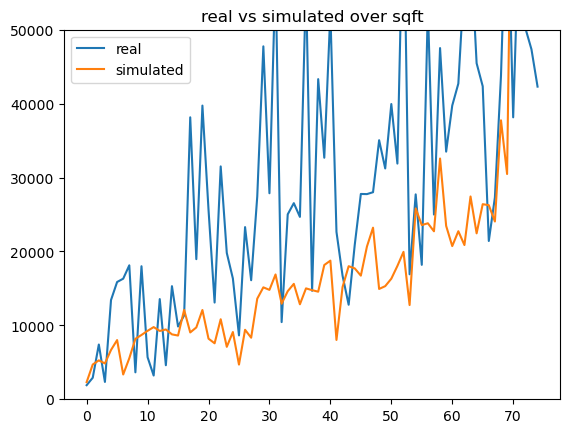

In [261]:
IL_furnace_centralAC_metadata_plot = IL_furnace_centralAC_metadata.sort_values(by = ['in.sqft'])

print("ResStock median HVAC:", np.median(IL_furnace_centralAC_metadata_plot['total_hvac']))
print("Simulation median HVAC:", np.median(IL_furnace_centralAC_metadata_plot['Sim_total_hvac']))

x = list(range(0,len(IL_furnace_centralAC_metadata_plot.index)))
plt.plot(x,IL_furnace_centralAC_metadata_plot['total_hvac'],label = "real")
plt.plot(x,IL_furnace_centralAC_metadata_plot['Sim_total_hvac'],label = "simulated")
plt.ylim([0,50000])
plt.legend()
plt.title("real vs simulated over sqft")

##### Illinois comparison of furnace with AC to heat pump system

In [178]:
IL_furnace_centralAC_metadata['heat_pump_HVAC_electricity'] = list(np.zeros(IL_furnace_centralAC_metadata.shape[0]))
IL_furnace_centralAC_metadata['heat_pump_naturalgas'] = list(np.zeros(IL_furnace_centralAC_metadata.shape[0]))
IL_furnace_centralAC_metadata['heat_pump_facility_electricity'] = list(np.zeros(IL_furnace_centralAC_metadata.shape[0]))

In [185]:
#update cooling and heating setpoints
directory  = r"/Applications/EnergyPlus-22-2-0/CCRG_Simulations/Furnace_CentralAC_Sanity_Check/"
defaultHouse = r"/Applications/EnergyPlus-22-2-0/ExampleFiles/AirflowNetwork_MultiZone_House_TwoSpeed.idf"
weatherDir = r"/Users/kyan/opt/anaconda3/lib/python3.9/site-packages/diyepw/data/tmy_epw_files/"

i = 1

outputVariables = [
    'Electricity:Facility [J](RunPeriod)'
    'Electricity:Building [J](RunPeriod)',
    'Electricity:HVAC [J](RunPeriod)',
    'NaturalGas:Facility [J](RunPeriod)',
    'NaturalGas:HVAC [J](RunPeriod)'
]

for index, house in IL_furnace_centralAC_metadata.iloc[:].iterrows():
    if i > 75: break
    idfFile = IDF(defaultHouse)
    
    idfFile.idfobjects["WindowMaterial:Gas"][0]['Thickness'] = 0.005
    updateSchedule(idfFile, house['in.cooling_setpoint'],house['in.cooling_setpoint_offset_magnitude'],house['in.cooling_setpoint_offset_period'],house['in.heating_setpoint'],house['in.heating_setpoint_offset_magnitude'],house['in.heating_setpoint_offset_period'])
    updateSQFT(idfFile,house['in.sqft'])
    changeLeakageRatio(idfFile, 0.0001)
    changeCrackFlow(idfFile, 0.0001)
    changeCrackFactor(idfFile, 0.01)
    updateLeakageRatio(idfFile, house['in.ducts'])
    idfFile.idfobjects['Coil:Heating:DX:MultiSpeed'][0]['Speed_1_Gross_Rated_Heating_COP'] = 4.4
    idfFile.idfobjects['Coil:Heating:DX:MultiSpeed'][0]['Speed_2_Gross_Rated_Heating_COP'] = 4.75

    idfFile.save(r"/Applications/EnergyPlus-22-2-0/ExampleFiles/furnace_CentralAC_sanity_check_HP_" + str(index) + ".idf")
    
    foldername = 'HP_'+str(index)
    houseFile = r"/Applications/EnergyPlus-22-2-0/ExampleFiles/furnace_CentralAC_sanity_check_HP_" + str(index) + ".idf"
    
    weatherFile = weatherDir + countiesLatsLons.loc[countiesLatsLons.index == house['FIPS']]['path1']
    data = runEnergyPlus(directory,foldername,weatherFile,houseFile)
    last_col = data.iloc[-1]
    
    for outputVariable in outputVariables:
        try: 
            if outputVariable == 'Electricity:Facility [J](RunPeriod)': 
                IL_furnace_centralAC_metadata.loc[index, 'heat_pump_facility_electricity'] = last_col[outputVariable] *  (2.777778*10**(-7))
            if outputVariable == 'Electricity:HVAC [J](RunPeriod)': 
                IL_furnace_centralAC_metadata.loc[index, 'heat_pump_HVAC_electricity'] = last_col[outputVariable] *  (2.777778*10**(-7))
            if outputVariable == 'NaturalGas:HVAC [J](RunPeriod)': 
                IL_furnace_centralAC_metadata.loc[index, 'heat_pump_naturalgas'] = last_col[outputVariable] * 2.777778*10**(-7)

        except Exception as e:
            try:
                if outputVariable == 'Electricity:Facility [J](RunPeriod)': 
                    IL_furnace_centralAC_metadata.loc[index, 'heat_pump_facility_electricity'] = last_col[outputVariable + ' '] *  2.777778*10**(-7)
                if outputVariable == 'Electricity:HVAC [J](RunPeriod)': 
                    IL_furnace_centralAC_metadata.loc[index, 'heat_pump_HVAC_electricity'] = last_col[outputVariable + ' '] *  2.777778*10**(-7)
                if outputVariable == 'NaturalGas:HVAC [J](RunPeriod)': 
                    IL_furnace_centralAC_metadata.loc[index, 'heat_pump_naturalgas'] = last_col[outputVariable + ' '] *  2.777778*10**(-7)
            except Exception as e:
                pass
            
    clear_output()
    
    cols_to_print = ['in.sqft',
                     'heat_pump_HVAC_electricity',
                     'heat_pump_naturalgas',
                     'Sim_total_hvac',
                     'total_hvac']
    print(IL_furnace_centralAC_metadata[cols_to_print][0:i])
    
    i+=1

         in.sqft  heat_pump_HVAC_electricity  heat_pump_naturalgas  \
bldg_id                                                              
91        2176.0                 7637.437609            786.223420   
139       1623.0                 6385.455779            128.822998   
226       2176.0                 9723.478019            133.177129   
240       2176.0                11196.161801              0.000000   
448       3301.0                18020.474437              0.000000   
...          ...                         ...                   ...   
3963      2176.0                12291.994495              0.000000   
4175      8194.0                44942.914662           7404.356976   
4177      2663.0                11756.696461            237.373543   
4186      2663.0                13313.790702              0.000000   
4210      8194.0                45289.292610           1062.782685   

         Sim_total_hvac    total_hvac  
bldg_id                                
91       

HP median HVAC: 8405.925679317814
Furnace median HVAC: 8734.697029836387
HP mean HVAC: 11232.328126447153
Furnace mean HVAC: 14111.829279148544


Text(0.5, 1.0, 'furnace vs heat pump over sqft')

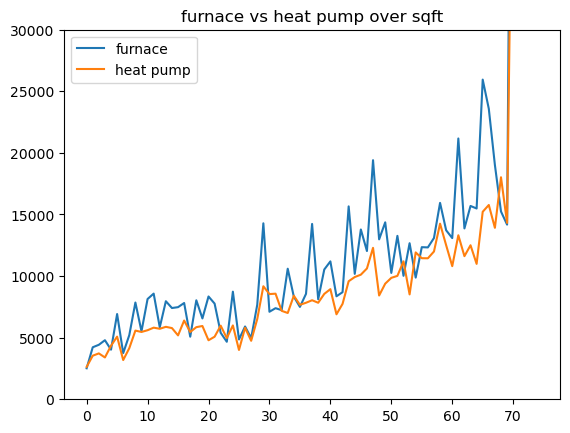

In [199]:
IL_furnace_centralAC_metadata['HP_total_hvac'] = IL_furnace_centralAC_metadata['heat_pump_HVAC_electricity'] + IL_furnace_centralAC_metadata['heat_pump_naturalgas']

IL_furnace_centralAC_metadata_plot = IL_furnace_centralAC_metadata.sort_values(by = ['in.sqft'])

print("HP median HVAC:", np.median(IL_furnace_centralAC_metadata_plot['HP_total_hvac']))
print("Furnace median HVAC:", np.median(IL_furnace_centralAC_metadata_plot['Sim_total_hvac']))

print("HP mean HVAC:", np.mean(IL_furnace_centralAC_metadata_plot['HP_total_hvac']))
print("Furnace mean HVAC:", np.mean(IL_furnace_centralAC_metadata_plot['Sim_total_hvac']))

x = list(range(0,len(IL_furnace_centralAC_metadata_plot.index)))
plt.plot(x,IL_furnace_centralAC_metadata_plot['Sim_total_hvac'],label = "furnace")
plt.plot(x,IL_furnace_centralAC_metadata_plot['HP_total_hvac'],label = "heat pump")
plt.ylim([0,30000])
plt.legend()
plt.title("furnace vs heat pump over sqft")

##### California HP vs Furnace + AC Sanity Check

In [206]:
CA_furnace_centralAC_metadata = US_metadata.loc[(
    (US_metadata["in.hvac_heating_type_and_fuel"] == "Natural Gas Fuel Furnace")
  | (US_metadata["in.hvac_heating_type_and_fuel"] == "Electricity Electric Furnace") 
  | (US_metadata["in.hvac_heating_type_and_fuel"] == "Fuel Oil Fuel Furnace") 
  | (US_metadata["in.hvac_heating_type_and_fuel"] == "Propane Fuel Furnace"))
  & (US_metadata['in.hvac_cooling_type'] == 'Central AC')
  & (US_metadata['in.state'] == 'CA')
]

newCounty = [county[1:3] + county[4:7] for county in CA_furnace_centralAC_metadata['in.county']]
CA_furnace_centralAC_metadata['FIPS'] = newCounty

cooling_setpoints = [int(setpointString[:-1]) for setpointString in list(CA_furnace_centralAC_metadata['in.cooling_setpoint']) ]
CA_furnace_centralAC_metadata['in.cooling_setpoint'] = cooling_setpoints

heating_setpoints = [int(setpointString[:-1]) for setpointString in list(CA_furnace_centralAC_metadata['in.heating_setpoint']) ]
CA_furnace_centralAC_metadata['in.heating_setpoint'] = heating_setpoints

cooling_offsets = [int(setpointString[:-1]) for setpointString in list(CA_furnace_centralAC_metadata['in.cooling_setpoint_offset_magnitude']) ]
CA_furnace_centralAC_metadata['in.cooling_setpoint_offset_magnitude'] = cooling_offsets

heating_offsets = [int(setpointString[:-1]) for setpointString in list(CA_furnace_centralAC_metadata['in.heating_setpoint_offset_magnitude']) ]
CA_furnace_centralAC_metadata['in.heating_setpoint_offset_magnitude'] = heating_offsets

CA_furnace_centralAC_metadata['Electricity:Facility [J](RunPeriod)'] = list(np.zeros(CA_furnace_centralAC_metadata.shape[0]))
CA_furnace_centralAC_metadata['Electricity:Building [J](RunPeriod)'] = list(np.zeros(CA_furnace_centralAC_metadata.shape[0]))
CA_furnace_centralAC_metadata['Electricity:HVAC [J](RunPeriod)'] = list(np.zeros(CA_furnace_centralAC_metadata.shape[0]))
CA_furnace_centralAC_metadata['NaturalGas:Facility [J](RunPeriod)'] = list(np.zeros(CA_furnace_centralAC_metadata.shape[0]))
CA_furnace_centralAC_metadata['NaturalGas:HVAC [J](RunPeriod)'] = list(np.zeros(CA_furnace_centralAC_metadata.shape[0]))
CA_furnace_centralAC_metadata['Propane:HVAC [J](RunPeriod)'] = list(np.zeros(CA_furnace_centralAC_metadata.shape[0]))

CA_furnace_centralAC_metadata['total_hvac'] = get_total_HVAC(CA_furnace_centralAC_metadata)
CA_furnace_centralAC_metadata['total_electricity'] = CA_furnace_centralAC_metadata['out.electricity.cooling.energy_consumption.kwh'] + CA_furnace_centralAC_metadata['out.electricity.heating.energy_consumption.kwh']
CA_furnace_centralAC_metadata['total_hvac'] /=  (2.777778*10**(-7))
CA_furnace_centralAC_metadata['total_electricity'] /=  (2.777778*10**(-7))

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user

In [224]:
#update cooling and heating setpoints
directory  = r"/Applications/EnergyPlus-22-2-0/CCRG_Simulations/CAFurnace_CentralAC_Sanity_Check/"
defaultHouse = r"/Applications/EnergyPlus-22-2-0/ExampleFiles/furnace_simulation_template.idf"
weatherDir = r"/Users/kyan/opt/anaconda3/lib/python3.9/site-packages/diyepw/data/tmy_epw_files/"

outputVariables = [
    'Electricity:Facility [J](RunPeriod)'
    'Electricity:Building [J](RunPeriod)',
    'Electricity:HVAC [J](RunPeriod)',
    'NaturalGas:Facility [J](RunPeriod)',
    'NaturalGas:HVAC [J](RunPeriod)',
    'Propane:HVAC [J](RunPeriod)'
]

i = 1
for index, house in CA_furnace_centralAC_metadata.iloc[:].iterrows():
    if i > 75: break
    idfFile = IDF(defaultHouse)
    
    fuel = getFuel(house['in.hvac_heating_type_and_fuel'])
    furnacetype = house['in.hvac_heating_efficiency']
    coolingEfficiency = house['in.hvac_cooling_efficiency']
    createFurnaceCentralAC(idfFile, fuel, coolingEfficiency, furnacetype,"Air Loop Inlet Node", "Air Loop Outlet Node")
    
    idfFile.idfobjects["WindowMaterial:Gas"][0]['Thickness'] = 0.005
    updateSchedule(idfFile, house['in.cooling_setpoint'],house['in.cooling_setpoint_offset_magnitude'],house['in.cooling_setpoint_offset_period'],house['in.heating_setpoint'],house['in.heating_setpoint_offset_magnitude'],house['in.heating_setpoint_offset_period'])
    updateSQFT(idfFile,house['in.sqft'])
    changeLeakageRatio(idfFile, 0.0001)
    changeCrackFlow(idfFile, 0.0001)
    changeCrackFactor(idfFile, 0.01)
    updateLeakageRatio(idfFile, house['in.ducts'])

    idfFile.save(r"/Applications/EnergyPlus-22-2-0/ExampleFiles/furnace_CentralAC_sanity_check_" + str(index) + ".idf")
    
    foldername = str(index)
    houseFile = r"/Applications/EnergyPlus-22-2-0/ExampleFiles/furnace_CentralAC_sanity_check_" + str(index) + ".idf"
    #weatherFile= r"/Applications/EnergyPlus-22-2-0/WeatherData/Chicago5A.epw"
    weatherFile = weatherDir + countiesLatsLons.loc[countiesLatsLons.index == house['FIPS']]['path1']
    #print(weatherFile)
    data = runEnergyPlus(directory,foldername,weatherFile,houseFile)
    last_col = data.iloc[-1]
    #print(last_col)
    
    for outputVariable in outputVariables:
        try: 
            CA_furnace_centralAC_metadata.loc[index, outputVariable] = last_col[outputVariable]
        except Exception as e:
            try:
                CA_furnace_centralAC_metadata.loc[index, outputVariable] = last_col[outputVariable + ' ']
            except Exception as e:
                pass

    clear_output()
    
    cols_to_print = ['in.sqft',
                     'Electricity:Facility [J](RunPeriod)',
                     'Electricity:Building [J](RunPeriod)',
                     'Electricity:HVAC [J](RunPeriod)',
                     'NaturalGas:Facility [J](RunPeriod)',
                     'NaturalGas:HVAC [J](RunPeriod)',
                     'Propane:HVAC [J](RunPeriod)',
                     'total_hvac',
                     'total_electricity']
    print(CA_furnace_centralAC_metadata[cols_to_print][0:i])
    i+=1

         in.sqft  Electricity:Facility [J](RunPeriod)  \
bldg_id                                                 
16        2176.0                                  0.0   
111       3301.0                                  0.0   
172       2176.0                                  0.0   
204       1690.0                                  0.0   
298       1690.0                                  0.0   
...          ...                                  ...   
1671      2176.0                                  0.0   
1698      2176.0                                  0.0   
1707      1138.0                                  0.0   
1722      2663.0                                  0.0   
1736      1690.0                                  0.0   

         Electricity:Building [J](RunPeriod)  Electricity:HVAC [J](RunPeriod)  \
bldg_id                                                                         
16                                       0.0                     2.193802e+10   
111            

In [225]:
CA_furnace_centralAC_metadata['Electricity:Facility [J](RunPeriod)'] *=  2.777778*10**(-7)
CA_furnace_centralAC_metadata['Electricity:Building [J](RunPeriod)']*=  2.777778*10**(-7)
CA_furnace_centralAC_metadata['Electricity:HVAC [J](RunPeriod)']*=  2.777778*10**(-7)
CA_furnace_centralAC_metadata['NaturalGas:Facility [J](RunPeriod)']*=  2.777778*10**(-7)
CA_furnace_centralAC_metadata['NaturalGas:HVAC [J](RunPeriod)']*=  2.777778*10**(-7)
CA_furnace_centralAC_metadata['Propane:HVAC [J](RunPeriod)']*=  2.777778*10**(-7)
CA_furnace_centralAC_metadata['total_hvac'] *=  (2.777778*10**(-7))
CA_furnace_centralAC_metadata['total_electricity'] *=  (2.777778*10**(-7))
CA_furnace_centralAC_metadata['Sim_total_hvac'] = CA_furnace_centralAC_metadata['Electricity:HVAC [J](RunPeriod)'] + CA_furnace_centralAC_metadata['NaturalGas:HVAC [J](RunPeriod)'] + CA_furnace_centralAC_metadata['Propane:HVAC [J](RunPeriod)']

CA_furnace_centralAC_metadata = CA_furnace_centralAC_metadata.iloc[0:75]

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user

ResStock median HVAC: 4953.19415407
Simulation median HVAC: 5553.688779069687


Text(0.5, 1.0, 'real vs simulated over sqft')

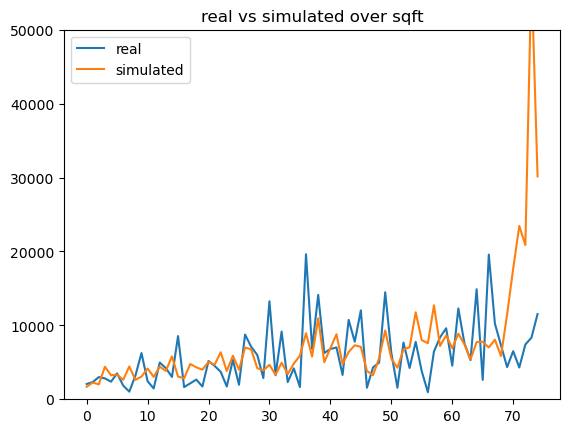

In [233]:
CA_furnace_centralAC_metadata_plot = CA_furnace_centralAC_metadata.sort_values(by = ['in.sqft'])

print("ResStock median HVAC:", np.median(CA_furnace_centralAC_metadata_plot['total_hvac']))
print("Simulation median HVAC:", np.median(CA_furnace_centralAC_metadata_plot['Sim_total_hvac']))

x = list(range(0,len(CA_furnace_centralAC_metadata_plot.index)))
plt.plot(x,CA_furnace_centralAC_metadata_plot['total_hvac'],label = "real")
plt.plot(x,CA_furnace_centralAC_metadata_plot['Sim_total_hvac'],label = "simulated")
plt.ylim([0,50000])
plt.legend()
plt.title("real vs simulated over sqft")

##### California comparison with furnace vs heat pumps

In [227]:
CA_furnace_centralAC_metadata['heat_pump_HVAC_electricity'] = list(np.zeros(CA_furnace_centralAC_metadata.shape[0]))
CA_furnace_centralAC_metadata['heat_pump_naturalgas'] = list(np.zeros(CA_furnace_centralAC_metadata.shape[0]))
CA_furnace_centralAC_metadata['heat_pump_facility_electricity'] = list(np.zeros(CA_furnace_centralAC_metadata.shape[0]))

In [231]:
#update cooling and heating setpoints
directory  = r"/Applications/EnergyPlus-22-2-0/CCRG_Simulations/CAFurnace_CentralAC_Sanity_Check/"
defaultHouse = r"/Applications/EnergyPlus-22-2-0/ExampleFiles/furnace_simulation_template.idf"
weatherDir = r"/Users/kyan/opt/anaconda3/lib/python3.9/site-packages/diyepw/data/tmy_epw_files/"

i = 34

outputVariables = [
    'Electricity:Facility [J](RunPeriod)'
    'Electricity:Building [J](RunPeriod)',
    'Electricity:HVAC [J](RunPeriod)',
    'NaturalGas:Facility [J](RunPeriod)',
    'NaturalGas:HVAC [J](RunPeriod)'
]

for index, house in CA_furnace_centralAC_metadata.iloc[34:76].iterrows():
    if i > 75: break
    idfFile = IDF(defaultHouse)
    
    idfFile.idfobjects["WindowMaterial:Gas"][0]['Thickness'] = 0.005
    updateSchedule(idfFile, house['in.cooling_setpoint'],house['in.cooling_setpoint_offset_magnitude'],house['in.cooling_setpoint_offset_period'],house['in.heating_setpoint'],house['in.heating_setpoint_offset_magnitude'],house['in.heating_setpoint_offset_period'])
    updateSQFT(idfFile,house['in.sqft'])
    changeLeakageRatio(idfFile, 0.0001)
    changeCrackFlow(idfFile, 0.0001)
    changeCrackFactor(idfFile, 0.01)
    updateLeakageRatio(idfFile, house['in.ducts'])
    idfFile.idfobjects['Coil:Heating:DX:MultiSpeed'][0]['Speed_1_Gross_Rated_Heating_COP'] = 3.75
    idfFile.idfobjects['Coil:Heating:DX:MultiSpeed'][0]['Speed_2_Gross_Rated_Heating_COP'] = 4.0

    idfFile.save(r"/Applications/EnergyPlus-22-2-0/ExampleFiles/furnace_CentralAC_sanity_check_HP_" + str(index) + ".idf")
    
    foldername = 'HP_'+str(index)
    houseFile = r"/Applications/EnergyPlus-22-2-0/ExampleFiles/furnace_CentralAC_sanity_check_HP_" + str(index) + ".idf"
    
    weatherFile = weatherDir + countiesLatsLons.loc[countiesLatsLons.index == house['FIPS']]['path1']
    try:
        data = runEnergyPlus(directory,foldername,weatherFile,houseFile)
        last_col = data.iloc[-1]
    except Exception as e:
        pass
        #if simulation failed for any reason

    for outputVariable in outputVariables:
        try: 
            if outputVariable == 'Electricity:Facility [J](RunPeriod)': 
                CA_furnace_centralAC_metadata.loc[index, 'heat_pump_facility_electricity'] = last_col[outputVariable] *  (2.777778*10**(-7))
            if outputVariable == 'Electricity:HVAC [J](RunPeriod)': 
                CA_furnace_centralAC_metadata.loc[index, 'heat_pump_HVAC_electricity'] = last_col[outputVariable] *  (2.777778*10**(-7))
            if outputVariable == 'NaturalGas:HVAC [J](RunPeriod)': 
                CA_furnace_centralAC_metadata.loc[index, 'heat_pump_naturalgas'] = last_col[outputVariable] * 2.777778*10**(-7)

        except Exception as e:
            try:
                if outputVariable == 'Electricity:Facility [J](RunPeriod)': 
                    CA_furnace_centralAC_metadata.loc[index, 'heat_pump_facility_electricity'] = last_col[outputVariable + ' '] *  2.777778*10**(-7)
                if outputVariable == 'Electricity:HVAC [J](RunPeriod)': 
                    CA_furnace_centralAC_metadata.loc[index, 'heat_pump_HVAC_electricity'] = last_col[outputVariable + ' '] *  2.777778*10**(-7)
                if outputVariable == 'NaturalGas:HVAC [J](RunPeriod)': 
                    CA_furnace_centralAC_metadata.loc[index, 'heat_pump_naturalgas'] = last_col[outputVariable + ' '] *  2.777778*10**(-7)
            except Exception as e:
                pass
            
    clear_output()
    
    cols_to_print = ['in.sqft',
                     'heat_pump_HVAC_electricity',
                     'heat_pump_naturalgas',
                     'Sim_total_hvac',
                     'total_hvac']
    print(CA_furnace_centralAC_metadata[cols_to_print][0:i])
    
    i+=1

         in.sqft  heat_pump_HVAC_electricity  heat_pump_naturalgas  \
bldg_id                                                              
16        2176.0                 5653.655032              0.000000   
111       3301.0                15132.225723              0.000000   
172       2176.0                 6055.262887              0.000000   
204       1690.0                 6217.022745              0.000000   
298       1690.0                 5914.237383              0.000000   
...          ...                         ...                   ...   
1669      1690.0                 5810.824610              0.000000   
1671      2176.0                 6350.036566              0.000000   
1698      2176.0                 5849.538380              0.000000   
1707      1138.0                 3842.937645              0.000000   
1722      2663.0                 4996.640548              4.499477   

         Sim_total_hvac    total_hvac  
bldg_id                                
16       

HP median HVAC: 4838.5070320916675
Furnace median HVAC: 5553.688779069687
HP mean HVAC: 6038.949107819925
Furnace mean HVAC: 7312.420056599363


Text(0.5, 1.0, 'furnace vs heat pump over sqft')

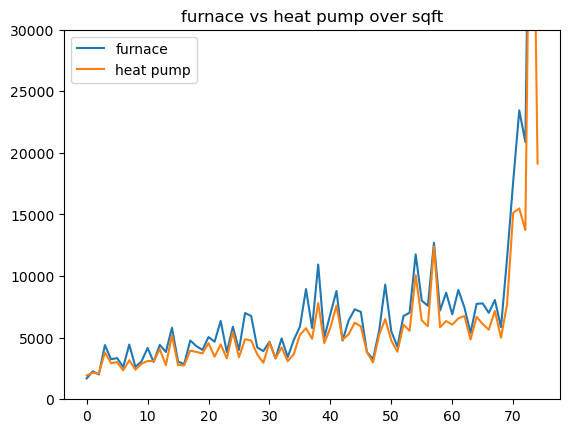

In [232]:
CA_furnace_centralAC_metadata['HP_total_hvac'] = CA_furnace_centralAC_metadata['heat_pump_HVAC_electricity'] + CA_furnace_centralAC_metadata['heat_pump_naturalgas']

CA_furnace_centralAC_metadata_plot = CA_furnace_centralAC_metadata.sort_values(by = ['in.sqft'])

print("HP median HVAC:", np.median(CA_furnace_centralAC_metadata_plot['HP_total_hvac']))
print("Furnace median HVAC:", np.median(CA_furnace_centralAC_metadata_plot['Sim_total_hvac']))

print("HP mean HVAC:", np.mean(CA_furnace_centralAC_metadata_plot['HP_total_hvac']))
print("Furnace mean HVAC:", np.mean(CA_furnace_centralAC_metadata_plot['Sim_total_hvac']))

x = list(range(0,len(CA_furnace_centralAC_metadata_plot.index)))
plt.plot(x,CA_furnace_centralAC_metadata_plot['Sim_total_hvac'],label = "furnace")
plt.plot(x,CA_furnace_centralAC_metadata_plot['HP_total_hvac'],label = "heat pump")
plt.ylim([0,30000])
plt.legend()
plt.title("furnace vs heat pump over sqft")

#### Boiler

In [235]:
boiler = idfFile.newidfobject("Boiler:Steam")

In [237]:
boiler.objls

['key',
 'Name',
 'Fuel_Type',
 'Maximum_Operating_Pressure',
 'Theoretical_Efficiency',
 'Design_Outlet_Steam_Temperature',
 'Nominal_Capacity',
 'Minimum_Part_Load_Ratio',
 'Maximum_Part_Load_Ratio',
 'Optimum_Part_Load_Ratio',
 'Coefficient_1_of_Fuel_Use_Function_of_Part_Load_Ratio_Curve',
 'Coefficient_2_of_Fuel_Use_Function_of_Part_Load_Ratio_Curve',
 'Coefficient_3_of_Fuel_Use_Function_of_Part_Load_Ratio_Curve',
 'Water_Inlet_Node_Name',
 'Steam_Outlet_Node_Name',
 'Sizing_Factor',
 'EndUse_Subcategory']

In [243]:
boiler['Name'] = boilerName
boiler['Fuel_Type'] = "NaturalGas"
boiler['Nominal_Capacity'] = 'autosize'
boiler['Minimum_Part_Load_Ratio'] = 0.00001
boiler['Maximum_Part_Load_Ratio'] = 1.0
boiler['Optimum_Part_Load_Ratio'] = 0.2
boiler['Coefficient_1_of_Fuel_Use_Function_of_Part_Load_Ratio_Curve'] = 0.8
boiler['Coefficient_2_of_Fuel_Use_Function_of_Part_Load_Ratio_Curve'] = 0.1
boiler['Coefficient_3_of_Fuel_Use_Function_of_Part_Load_Ratio_Curve'] = 0.1
boiler['Water_Inlet_Node_Name'] = 
boiler['Steam_Outlet_Node_Name'] = 



# Steam Boiler Plant Boiler, !- Boiler Name
# NaturalGas , !- Fuel Type
# 160000, !-Maximum Boiler Pressure Pascal
# 0.8, !- Theoretical Boiler Efficiency
# 115, !- Max Design Outlet Steam Temp
# 300000, !- Nominal Capacity W
# 0.00001, !- Minimum Part Load Ratio
# 1.0, !- Maximum Part Load Ratio
# 0.2, !- Optimum Part Load Ratio
# 0.8,!- Coefficient 1 of the fuel use/part load ratio curve
# 0.1,!- Coefficient 2 of the fuel use/part load ratio curve
# 0.1,!- Coefficient 3 of the fuel use/part load ratio curve
# Steam Boiler Plant Boiler Inlet Node, !- Boiler Steam Inlet Node
# Steam Boiler Plant Boiler Outlet Node; !- Plant Loop Outlet Node

In [244]:
boiler


BOILER:STEAM,
    ,                         !- Name
    NaturalGas,               !- Fuel Type
    160000,                   !- Maximum Operating Pressure
    0.8,                      !- Theoretical Efficiency
    100,                      !- Design Outlet Steam Temperature
    autosize,                 !- Nominal Capacity
    1e-05,                    !- Minimum Part Load Ratio
    1,                        !- Maximum Part Load Ratio
    0.2,                      !- Optimum Part Load Ratio
    0.8,                      !- Coefficient 1 of Fuel Use Function of Part Load Ratio Curve
    0.1,                      !- Coefficient 2 of Fuel Use Function of Part Load Ratio Curve
    0.1,                      !- Coefficient 3 of Fuel Use Function of Part Load Ratio Curve
    ,                         !- Water Inlet Node Name
    ,                         !- Steam Outlet Node Name
    1,                        !- Sizing Factor
    General;                  !- EndUse Subcategory

#### furnace no Cooling (can't get coil autosizing to work and values are way off rn)

##### createFurnaceNoCooling Function

In [84]:
def getFurnaceEfficiency(description):
    return float(description.split(", ")[1].split("%")[0])/100

def createFurnaceCoil(idfFile, name, fuel, typedescription,inletName, outletName):
    if fuel == "Electricity":
        x = idfFile.newidfobject('Coil:Heating:Electric')
        x['Name'] = name
        x['Availability_Schedule_Name'] = "HVACAvailSched"
        x['Efficiency'] = getFurnaceEfficiency(typedescription)
        x['Nominal_Capacity'] = 'autosize'
        x['Air_Inlet_Node_Name'] = inletName
        x['Air_Outlet_Node_Name'] = outletName
    else:
        x = idfFile.newidfobject("Coil:Heating:Fuel")
        x['Availability_Schedule_Name'] = "HVACAvailSched"
        x['Name'] = name
        x["Fuel_Type"] = fuel
        x['Burner_Efficiency'] = getFurnaceEfficiency(typedescription)
        x['Nominal_Capacity'] = 'autosize'
        x['Air_Inlet_Node_Name'] = inletName
        x['Air_Outlet_Node_Name'] = outletName
        
    
def createFurnaceNoCooling(idfFile, fuel, typedescription,inletName,outletName):
    #delete existing objects
    idfFile.removeidfobject(idfFile.idfobjects['AirLoopHVAC:UnitaryHeatPump:AirToAir:MultiSpeed'][0])
    idfFile.removeidfobject(idfFile.idfobjects['Coil:Heating:DX:MultiSpeed'][0])
    idfFile.removeidfobject(idfFile.idfobjects['Coil:Cooling:DX:MultiSpeed'][0])
    idfFile.removeidfobject(idfFile.idfobjects['Coil:Heating:Fuel'][0])
    
    #create furnace heating coil
    heatingCoilInlet = "Heating Coil Air Inlet Node"
    heatingCoilOutlet = outletName
    createFurnaceCoil(idfFile, "Furnace Coil",fuel, typedescription, heatingCoilInlet, heatingCoilOutlet)
    
    #update supply fan 1
    supplyFan = idfFile.idfobjects['Fan:OnOff'][0]
    supplyFan['Air_Inlet_Node_Name'] = inletName
    supplyFan['Air_Outlet_Node_Name'] = heatingCoilInlet
                      
    #create AirLoopHVAC object
    Furnace = idfFile.newidfobject('AirLoopHVAC:Unitary:Furnace:HeatOnly')
    Furnace['Name'] = "Furnace"
    Furnace['Availability_Schedule_Name'] = 'HVACAvailSched'
    Furnace['Furnace_Air_Inlet_Node_Name'] = inletName
    Furnace['Furnace_Air_Outlet_Node_Name'] = outletName
    Furnace['Supply_Air_Fan_Operating_Mode_Schedule_Name'] = 'CyclingFanSchedule'
    Furnace['Heating_Supply_Air_Flow_Rate'] = 'autosize'
    Furnace['Controlling_Zone_or_Thermostat_Location'] = 'LIVING ZONE'
    Furnace['Supply_Fan_Object_Type'] = 'Fan:OnOff'
    Furnace['Supply_Fan_Name'] = supplyFan['Name']
    Furnace['Fan_Placement'] = 'BlowThrough'
    Furnace['Heating_Coil_Name'] = "Furnace Coil"
    
    if fuel == "Electricity":
        Furnace['Heating_Coil_Object_Type'] = 'Coil:Heating:Electric'
    else:
        Furnace['Heating_Coil_Object_Type'] = 'Coil:Heating:Fuel'

    
    #change branch references
    Branch = idfFile.idfobjects['Branch'][0]
    Branch['Component_1_Object_Type'] = 'AirLoopHVAC:Unitary:Furnace:HeatOnly'
    Branch['Component_1_Name'] = 'Furnace'
    Branch['Component_1_Inlet_Node_Name'] = inletName
    Branch['Component_1_Outlet_Node_Name'] = outletName
    
    #remove coolingInletNode
    for node in idfFile.idfobjects['AirflowNetwork:Distribution:Node']:
        if node['Name'] == 'CoolingInletNode': 
            coolingInletNode = node
        if node['Name'] == 'SuppHeatingInletNode': 
            supheating = node
    idfFile.removeidfobject(coolingInletNode)
    idfFile.removeidfobject(supheating)

    
    #update duct linkages
    for linkage in idfFile.idfobjects['AirflowNetwork:Distribution:Linkage']:
        if linkage['Name'] == 'SupplyFanLink':
            linkage['Node_2_Name'] = 'HeatingInletNode'
        if linkage['Name'] == 'SuppHeatingCoilLink':
            linkage['Node_2_Name'] = 'AirLoopOutletNode'
            linkage['Node_1_Name'] = 'HeatingInletNode'
            linkage['Component_Name'] = 'Furnace Coil'
        if linkage['Name'] == 'HeatingCoilLink': heatingCoil = linkage
        if linkage['Name'] == 'CoolingCoilLink': coolingCoil = linkage

    idfFile.removeidfobject(coolingCoil)
    idfFile.removeidfobject(heatingCoil)

    
    #delete unused coils
    for distributionCoil in idfFile.idfobjects['AirflowNetwork:Distribution:Component:Coil']:
        if distributionCoil['Coil_Name'] == 'ACDXCoil 1': 
            adxcoil = distributionCoil
        if distributionCoil['Coil_Name'] == 'Heat Pump DX Heating Coil 1': 
            dcheatingcoil = distributionCoil
        if distributionCoil['Coil_Name'] == 'Supp Heating Coil 1':  
            distributionCoil['Coil_Name'] = 'Furnace Coil'
            if fuel == "Electricity":
                distributionCoil['Coil_Object_Type'] = 'Coil:Heating:Electric'
                
    idfFile.removeidfobject(dcheatingcoil)
    idfFile.removeidfobject(adxcoil)
    
    #remove outdoor air node, not needed for furnace
    idfFile.removeidfobject(idfFile.idfobjects['OutdoorAir:Node'][0])


##### Furnace no Cooling Sanity Check

In [129]:
IL_furnace_noCooling_metadata = IL_metadata.loc[(
    (IL_metadata["in.hvac_heating_type_and_fuel"] == "Natural Gas Fuel Furnace")
  | (IL_metadata["in.hvac_heating_type_and_fuel"] == "Electricity Electric Furnace") 
  | (IL_metadata["in.hvac_heating_type_and_fuel"] == "Fuel Oil Fuel Furnace") 
  | (IL_metadata["in.hvac_heating_type_and_fuel"] == "Propane Fuel Furnace"))
  & (IL_metadata['in.hvac_cooling_type'] == 'None')

]

cooling_setpoints = [int(setpointString[:-1]) for setpointString in list(IL_furnace_noCooling_metadata['in.cooling_setpoint']) ]
IL_furnace_noCooling_metadata['in.cooling_setpoint'] = cooling_setpoints

heating_setpoints = [int(setpointString[:-1]) for setpointString in list(IL_furnace_noCooling_metadata['in.heating_setpoint']) ]
IL_furnace_noCooling_metadata['in.heating_setpoint'] = heating_setpoints

cooling_offsets = [int(setpointString[:-1]) for setpointString in list(IL_furnace_noCooling_metadata['in.cooling_setpoint_offset_magnitude']) ]
IL_furnace_noCooling_metadata['in.cooling_setpoint_offset_magnitude'] = cooling_offsets

heating_offsets = [int(setpointString[:-1]) for setpointString in list(IL_furnace_noCooling_metadata['in.heating_setpoint_offset_magnitude']) ]
IL_furnace_noCooling_metadata['in.heating_setpoint_offset_magnitude'] = heating_offsets

IL_furnace_noCooling_metadata['Electricity:Facility [J](RunPeriod)'] = list(np.zeros(IL_furnace_noCooling_metadata.shape[0]))
IL_furnace_noCooling_metadata['Electricity:Building [J](RunPeriod)'] = list(np.zeros(IL_furnace_noCooling_metadata.shape[0]))
IL_furnace_noCooling_metadata['Electricity:HVAC [J](RunPeriod)'] = list(np.zeros(IL_furnace_noCooling_metadata.shape[0]))
IL_furnace_noCooling_metadata['NaturalGas:Facility [J](RunPeriod)'] = list(np.zeros(IL_furnace_noCooling_metadata.shape[0]))
IL_furnace_noCooling_metadata['NaturalGas:HVAC [J](RunPeriod)'] = list(np.zeros(IL_furnace_noCooling_metadata.shape[0]))
IL_furnace_noCooling_metadata['Propane:HVAC [J](RunPeriod)'] = list(np.zeros(IL_furnace_noCooling_metadata.shape[0]))

IL_furnace_noCooling_metadata['total_hvac'] = IL_furnace_noCooling_metadata['out.electricity.cooling.energy_consumption.kwh'] + IL_furnace_noCooling_metadata['out.electricity.heating.energy_consumption.kwh'] + IL_furnace_noCooling_metadata['out.fuel_oil.heating.energy_consumption.kwh'] + IL_furnace_noCooling_metadata['out.natural_gas.heating.energy_consumption.kwh'] + IL_furnace_noCooling_metadata['out.propane.heating.energy_consumption.kwh']
IL_furnace_noCooling_metadata['total_electricity'] = IL_furnace_noCooling_metadata['out.electricity.cooling.energy_consumption.kwh'] + IL_furnace_noCooling_metadata['out.electricity.heating.energy_consumption.kwh']
IL_furnace_noCooling_metadata['total_hvac'] /=  (2.777778*10**(-7))
IL_furnace_noCooling_metadata['total_electricity'] /=  (2.777778*10**(-7))

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user

In [86]:
#update cooling and heating setpoints
directory  = r"/Applications/EnergyPlus-22-2-0/CCRG_Simulations/Furnace_noAC_Sanity_Check_noleaks/"
defaultHouse = r"/Applications/EnergyPlus-22-2-0/ExampleFiles/AirflowNetwork_MultiZone_House_TwoSpeed.idf"
weatherDir = r"/Users/kyan/opt/anaconda3/lib/python3.9/site-packages/diyepw/data/tmy_epw_files/"

outputVariables = [
    'Electricity:Facility [J](RunPeriod)'
    'Electricity:Building [J](RunPeriod)',
    'Electricity:HVAC [J](RunPeriod)',
    'NaturalGas:Facility [J](RunPeriod)',
    'NaturalGas:HVAC [J](RunPeriod)',
    'Propane:HVAC [J](RunPeriod)',
    'FuelOilNo1:HVAC [J](RunPeriod)'
]

i = 1
for index, house in IL_furnace_noCooling_metadata.iloc[:].iterrows():
    if i > 75: break
    idfFile = IDF(defaultHouse)
    
    fuel = getFuel(house['in.hvac_heating_type_and_fuel'])
    furnacetype = house['in.hvac_heating_efficiency']
    createFurnaceNoCooling(idfFile,fuel, furnacetype, "Air Loop Inlet Node", "Air Loop Outlet Node")
    
    idfFile.idfobjects["WindowMaterial:Gas"][0]['Thickness'] = 0.005
    updateSchedule(idfFile, house['in.cooling_setpoint'],house['in.cooling_setpoint_offset_magnitude'],house['in.cooling_setpoint_offset_period'],house['in.heating_setpoint'],house['in.heating_setpoint_offset_magnitude'],house['in.heating_setpoint_offset_period'])
    updateSQFT(idfFile,house['in.sqft'])
    changeLeakageRatio(idfFile, 0.0001)
    changeCrackFlow(idfFile, 0.0001)
    changeCrackFactor(idfFile, 0.01)
    updateLeakageRatio(idfFile, house['in.ducts'])

    idfFile.save(r"/Applications/EnergyPlus-22-2-0/ExampleFiles/furnace_noAC_sanity_check_" + str(index) + ".idf")
    
    foldername = str(index)
    houseFile = r"/Applications/EnergyPlus-22-2-0/ExampleFiles/furnace_noAC_sanity_check_" + str(index) + ".idf"
    #weatherFile= r"/Applications/EnergyPlus-22-2-0/WeatherData/Chicago5A.epw"
    weatherFile = weatherDir + countiesLatsLons.loc[countiesLatsLons.index == house['FIPS']]['path1']
    data = runEnergyPlus(directory,foldername,weatherFile,houseFile)
    last_col = data.iloc[-1]
    #print(last_col)
    
    for outputVariable in outputVariables:
        try: 
            IL_furnace_noCooling_metadata.loc[index, outputVariable] = last_col[outputVariable]
        except Exception as e:
            try:
                IL_furnace_noCooling_metadata.loc[index, outputVariable] = last_col[outputVariable + ' ']
            except Exception as e:
                pass

    clear_output()
    
    cols_to_print = ['in.sqft',
                     'Electricity:Facility [J](RunPeriod)',
                     'Electricity:Building [J](RunPeriod)',
                     'Electricity:HVAC [J](RunPeriod)',
                     'NaturalGas:Facility [J](RunPeriod)',
                     'NaturalGas:HVAC [J](RunPeriod)',
                     'Propane:HVAC [J](RunPeriod)',
                     'total_hvac',
                     'total_electricity']
    print(IL_furnace_noCooling_metadata[cols_to_print][0:i])
    i+=1

         in.sqft  Electricity:Facility [J](RunPeriod)  \
bldg_id                                                 
322        885.0                                  0.0   
622       1220.0                                  0.0   
1025      2663.0                                  0.0   
1860      1220.0                                  0.0   
2353       617.0                                  0.0   
2378       853.0                                  0.0   
3195       885.0                                  0.0   
3235       617.0                                  0.0   
3244       885.0                                  0.0   
3555      2176.0                                  0.0   
3640      3301.0                                  0.0   
3672       853.0                                  0.0   
3703       853.0                                  0.0   
4017      8194.0                                  0.0   
4090      1690.0                                  0.0   
4586       885.0               

KeyboardInterrupt: 

In [80]:
# IL_furnace_noCooling_metadata['Electricity:Facility [J](RunPeriod)'] *=  2.777778*10**(-7)
# IL_furnace_noCooling_metadata['Electricity:Building [J](RunPeriod)']*=  2.777778*10**(-7)
# IL_furnace_noCooling_metadata['Electricity:HVAC [J](RunPeriod)']*=  2.777778*10**(-7)
# IL_furnace_noCooling_metadata['NaturalGas:Facility [J](RunPeriod)']*=  2.777778*10**(-7)
# IL_furnace_noCooling_metadata['NaturalGas:HVAC [J](RunPeriod)']*=  2.777778*10**(-7)
# IL_furnace_noCooling_metadata['Propane:HVAC [J](RunPeriod)']*=  2.777778*10**(-7)
# IL_furnace_noCooling_metadata['total_hvac'] *=  (2.777778*10**(-7))
# IL_furnace_noCooling_metadata['total_electricity'] *=  (2.777778*10**(-7))
# IL_furnace_noCooling_metadata['Sim_total_hvac'] = IL_furnace_noCooling_metadata['Electricity:HVAC [J](RunPeriod)'] + IL_furnace_noCooling_metadata['NaturalGas:HVAC [J](RunPeriod)'] + IL_furnace_noCooling_metadata['Propane:HVAC [J](RunPeriod)']
# # IL_furnace_noCooling_metadata.to_csv("IL_furnace_noCooling_metadata.csv")

IL_furnace_noCooling_metadata = IL_furnace_noCooling_metadata.iloc[0:18]

ResStock median HVAC: 21265.82298134
Simulation median HVAC: 2968.1520548958433


Text(0.5, 1.0, 'real vs simulated over sqft')

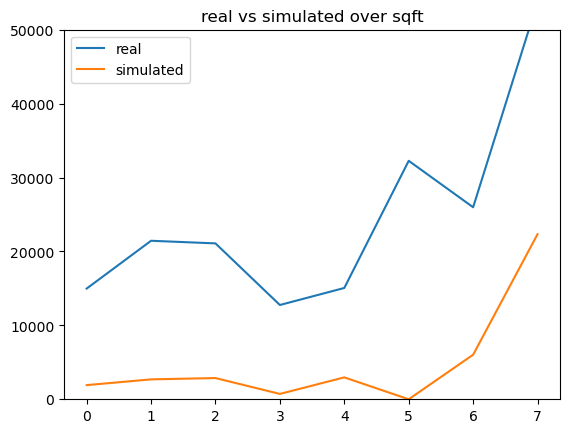

In [81]:
IL_furnace_noCooling_metadata_plot = IL_furnace_noCooling_metadata.sort_values(by = ['in.sqft'])

print("ResStock median HVAC:", np.median(IL_furnace_noCooling_metadata_plot['total_hvac']))
print("Simulation median HVAC:", np.median(IL_furnace_noCooling_metadata_plot['Sim_total_hvac']))

x = list(range(0,len(IL_furnace_noCooling_metadata_plot.index)))
plt.plot(x,IL_furnace_noCooling_metadata_plot['total_hvac'],label = "real")
plt.plot(x,IL_furnace_noCooling_metadata_plot['NaturalGas:HVAC [J](RunPeriod)'],label = "simulated")
plt.ylim([0,50000])
plt.legend()
plt.title("real vs simulated over sqft")

#### US and Illinois overview stats of total HVAC useage for heat pump vs furnace

In [149]:
print("median total_hvac furnace no cooling",np.median(IL_furnace_noCooling_metadata['total_hvac']) * (2.777778*10**(-7)) )
print("median total_hvac furnace central AC",np.median(IL_furnace_centralAC_metadata['total_hvac']) * (2.777778*10**(-7)) )
print("median total_hvac heatpump",np.median(IL_heatpump_metadata_noleaks['total_hvac']) )

print("median total_hvac furnace no cooling",np.median(IL_furnace_noCooling_metadata['in.sqft']) )
print("median total_hvac furnace central AC",np.median(IL_furnace_centralAC_metadata['in.sqft']) )
print("median total_hvac heatpump",np.median(IL_heatpump_metadata_noleaks['in.sqft']) )

print("median total_hvac furnace no cooling",np.median(IL_furnace_noCooling_metadata['in.heating_setpoint']) )
print("median total_hvac furnace central AC",np.median(IL_furnace_centralAC_metadata['in.heating_setpoint']) )
print("median total_hvac heatpump",np.median(IL_heatpump_metadata_noleaks['in.heating_setpoint']) )

IL_furnace_noCooling_metadata['total_hvac'] = IL_furnace_noCooling_metadata['out.electricity.cooling.energy_consumption.kwh'] + IL_furnace_noCooling_metadata['out.electricity.heating.energy_consumption.kwh'] + IL_furnace_noCooling_metadata['out.fuel_oil.heating.energy_consumption.kwh'] + IL_furnace_noCooling_metadata['out.natural_gas.heating.energy_consumption.kwh'] + IL_furnace_noCooling_metadata['out.propane.heating.energy_consumption.kwh']


median total_hvac furnace no cooling 23933.648931550004
median total_hvac furnace central AC 24047.65357778
median total_hvac heatpump 5016.350969655
median total_hvac furnace no cooling 1220.0
median total_hvac furnace central AC 1690.0
median total_hvac heatpump 1138.0
median total_hvac furnace no cooling 68.0
median total_hvac furnace central AC 68.0
median total_hvac heatpump 68.0


In [150]:
US_metadata['total_hvac'] = US_metadata['out.electricity.cooling.energy_consumption.kwh'] + US_metadata['out.electricity.heating.energy_consumption.kwh'] + US_metadata['out.fuel_oil.heating.energy_consumption.kwh'] + US_metadata['out.natural_gas.heating.energy_consumption.kwh'] + US_metadata['out.propane.heating.energy_consumption.kwh']


In [151]:
US_furnace_noCooling_metadata = US_metadata.loc[(
    (US_metadata["in.hvac_heating_type_and_fuel"] == "Natural Gas Fuel Furnace")
  | (US_metadata["in.hvac_heating_type_and_fuel"] == "Electricity Electric Furnace") 
  | (US_metadata["in.hvac_heating_type_and_fuel"] == "Fuel Oil Fuel Furnace") 
  | (US_metadata["in.hvac_heating_type_and_fuel"] == "Propane Fuel Furnace"))
  & (US_metadata['in.hvac_cooling_type'] == 'None')

]


In [153]:
US_furnace_CentralCooling_metadata = US_metadata.loc[(
    (US_metadata["in.hvac_heating_type_and_fuel"] == "Natural Gas Fuel Furnace")
  | (US_metadata["in.hvac_heating_type_and_fuel"] == "Electricity Electric Furnace") 
  | (US_metadata["in.hvac_heating_type_and_fuel"] == "Fuel Oil Fuel Furnace") 
  | (US_metadata["in.hvac_heating_type_and_fuel"] == "Propane Fuel Furnace"))
  & (US_metadata['in.hvac_cooling_type'] == 'Central AC')

]

In [155]:
US_heatpump = US_metadata.loc[(US_metadata['in.hvac_heating_type_and_fuel'] == "Electricity ASHP") & (US_metadata['in.hvac_cooling_type'] == "Heat Pump")]


In [156]:
print("median total_hvac furnace no cooling",np.median(US_furnace_noCooling_metadata['total_hvac'])  )
print("median total_hvac furnace central AC",np.median(US_furnace_CentralCooling_metadata['total_hvac']) )
print("median total_hvac heatpump",np.median(US_heatpump['total_hvac']) )

median total_hvac furnace no cooling 12466.65717566
median total_hvac furnace central AC 12739.359806295
median total_hvac heatpump 5520.140138985


In [636]:


x = idf1.newidfobject('Coil:Heating:Electric')

In [643]:
defaultHouse = r"/Applications/EnergyPlus-22-2-0/ExampleFiles/AirflowNetwork_MultiZone_House_TwoSpeed.idf"
idf1 = IDF(defaultHouse)
createFurnaceNoCooling(idf1, "Electricity", furnacetypes[0], "Air Loop Inlet Node", "Air Loop Outlet Node")
idf1.save(r"/Applications/EnergyPlus-22-2-0/ExampleFiles/furnaceTestEx.idf")